###Milestone 4 Summary

Team: Solaris Nexus: where solar energy meets global sustainability (**New York Academy of Sciences, Junior Academy**)

Challenge: Energy Infrastructure: Solar Power

#Team members:
***Aaditya K., Rishith S., Yelyzaveta M., Favour T., Jianxin Y., Hridhaan B.***

###Dataset: Solar Power Generation Data (Kaggle)
https://www.kaggle.com/datasets/anikannal/solar-power-generation-data

This notebook builds a full pipeline for solar forecasting and battery control using data from two real solar plants.

#Data Processing
	1. Load Plant 1 and Plant 2 generation + weather data
	2. Parse timestamps and merge using nearest matches
	3. Resample to 15-minute intervals
	4. Create features: hour, day of year, plant-level PV (kW), synthetic residential load        
	5. Final control dataframes: control_df_plant1, control_df_plant2

#Forecasting Models

###Trained on each plant using a 70/30 time-split:
	1. Persistence baseline
	2. Linear Regression
	3. Random Forest
	4. XGBoost

Outputs: MAE, R², and 1-day slice plots for both Plant 1 and Plant 2.

#Battery Environment

Implements a simple 10 kWh battery model with charge/discharge limits, round-trip efficiency, grid import/export, and reward based on energy cost and battery use.

#Controllers

###Five controllers are evaluated:
	1.  Rule-based
	2.	RL-only (tabular Q-learning)
	3.	Hybrid LR
	4.	Hybrid RF
	5.	Hybrid XGB

Hybrid methods use a one-step PV forecast to guide actions.

#Plant 1 Results

Hybrid controllers achieve large reductions in grid import while maintaining reasonable cycling.
RL-only reduces import but increases battery wear.
Rule-based performs the worst.

#Ablation Studies
	1.	Removing time features
	2.  Removing SoC regularization
	3.	Adding noise to forecasts

These tests show the stability of hybrid controllers.

#Cross-Site Generalization

Controllers trained only on Plant 1 are tested on Plant 2.
Hybrid controllers transfer well and remain efficient.

#Plots Produced
	1. Forecast comparisons (Plant 1, Plant 2)
	2. Controller comparisons (energy and cycles)
	3. Energy vs wear trade-off
	4. Time-feature ablation
	5. SoC-penalty ablation
	6. Forecast noise robustness
	7. Cross-site generalization bar chart


In [21]:
import pandas as pd
import numpy as np

gen_p1 = pd.read_csv("Plant_1_Generation_Data.csv")
weather_p1 = pd.read_csv("Plant_1_Weather_Sensor_Data.csv")

gen_p1["DATE_TIME"] = pd.to_datetime(gen_p1["DATE_TIME"], format="%d-%m-%Y %H:%M")
weather_p1["DATE_TIME"] = pd.to_datetime(weather_p1["DATE_TIME"], format="%Y-%m-%d %H:%M:%S")

gen_p1_agg = (
    gen_p1.groupby("DATE_TIME")[["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD"]]
    .sum()
    .sort_index()
)

weather_p1 = weather_p1.sort_values("DATE_TIME")

merged_p1 = pd.merge_asof(
    gen_p1_agg.reset_index().sort_values("DATE_TIME"),
    weather_p1[["DATE_TIME", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]],
    on="DATE_TIME"
)

merged_p1 = merged_p1.dropna().reset_index(drop=True)

merged_p1 = merged_p1.set_index("DATE_TIME").sort_index()
merged_p1 = merged_p1.resample("15T").agg({
    "DC_POWER": "sum",
    "AC_POWER": "sum",
    "DAILY_YIELD": "max",
    "TOTAL_YIELD": "max",
    "IRRADIATION": "mean",
    "AMBIENT_TEMPERATURE": "mean",
    "MODULE_TEMPERATURE": "mean"
}).dropna().reset_index()

merged_p1["hour"] = merged_p1["DATE_TIME"].dt.hour
merged_p1["day_of_year"] = merged_p1["DATE_TIME"].dt.dayofyear
merged_p1["pv_kw"] = merged_p1["AC_POWER"] / 1000.0

np.random.seed(42)
h = merged_p1["hour"].values
morning_peak = np.exp(-0.5 * ((h - 8) / 2)**2)
evening_peak = np.exp(-0.5 * ((h - 19) / 2)**2)
load_profile = 0.6 + morning_peak + 1.2 * evening_peak

merged_p1["load_kw"] = 2.0 * load_profile + 0.2 * np.random.randn(len(merged_p1))
merged_p1["load_kw"] = merged_p1["load_kw"].clip(lower=0.3)

control_df_plant1 = merged_p1.set_index("DATE_TIME")[[
    "pv_kw",
    "load_kw",
    "IRRADIATION",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "hour",
    "day_of_year"
]].copy()

print("Plant 1 control_df shape:", control_df_plant1.shape)
control_df_plant1.head(10)

Plant 1 control_df shape: (3158, 7)


/tmp/ipython-input-4182199494.py:27: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  merged_p1 = merged_p1.resample("15T").agg({


,pv_kw,load_kw,IRRADIATION,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,hour,day_of_year
DATE_TIME,,,,,,,
2020-05-15 00:00:00,0.0,1.300014,0.0,25.184316,22.857507,0,136
2020-05-15 00:15:00,0.0,1.173018,0.0,25.084589,22.761668,0,136
2020-05-15 00:30:00,0.0,1.330209,0.0,24.935753,22.592306,0,136
2020-05-15 00:45:00,0.0,1.505277,0.0,24.846130,22.360852,0,136
2020-05-15 01:00:00,0.0,1.157544,0.0,24.621525,22.165423,1,136
2020-05-15 01:15:00,0.0,1.157548,0.0,24.536092,21.968571,1,136
2020-05-15 01:30:00,0.0,1.520218,0.0,24.638674,22.352926,1,136
2020-05-15 01:45:00,0.0,1.357862,0.0,24.873022,23.160919,1,136
2020-05-15 02:00:00,0.0,1.128323,0.0,24.936930,23.026113,2,136


In [22]:
!pip install xgboost -q

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

data = control_df_plant1.sort_index().copy()

feature_cols = ["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "hour", "day_of_year"]
X = data[feature_cols]
y = data["pv_kw"]

split_idx = int(len(data) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

results = {}

pv_shift = data["pv_kw"].shift(1)
y_pred_persist_test = pv_shift.loc[y_test.index]
mask = ~y_pred_persist_test.isna()

results["Persistence"] = {
    "MAE": mean_absolute_error(y_test[mask], y_pred_persist_test[mask]),
    "R2": r2_score(y_test[mask], y_pred_persist_test[mask])
}

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
results["LinearRegression"] = {
    "MAE": mean_absolute_error(y_test, y_pred_lr),
    "R2": r2_score(y_test, y_pred_lr)
}

rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
results["RandomForest"] = {
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "R2": r2_score(y_test, y_pred_rf)
}

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
results["XGBoost"] = {
    "MAE": mean_absolute_error(y_test, y_pred_xgb),
    "R2": r2_score(y_test, y_pred_xgb)
}

print("\n=== Forecasting Baselines on Plant 1")
for k, v in results.items():
    print(f"{k:16s} | MAE = {v['MAE']:.4f} kW | R² = {v['R2']:.4f}")

Train size: (2210, 5) Test size: (948, 5)

=== Forecasting Baselines on Plant 1
Persistence      | MAE = 1.1621 kW | R² = 0.9269
LinearRegression | MAE = 0.4636 kW | R² = 0.9917
RandomForest     | MAE = 0.3317 kW | R² = 0.9917
XGBoost          | MAE = 0.4160 kW | R² = 0.9882


/tmp/ipython-input-185289690.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  persist_slice = persist_full.loc[y_test.index[:96]].fillna(method="bfill").values


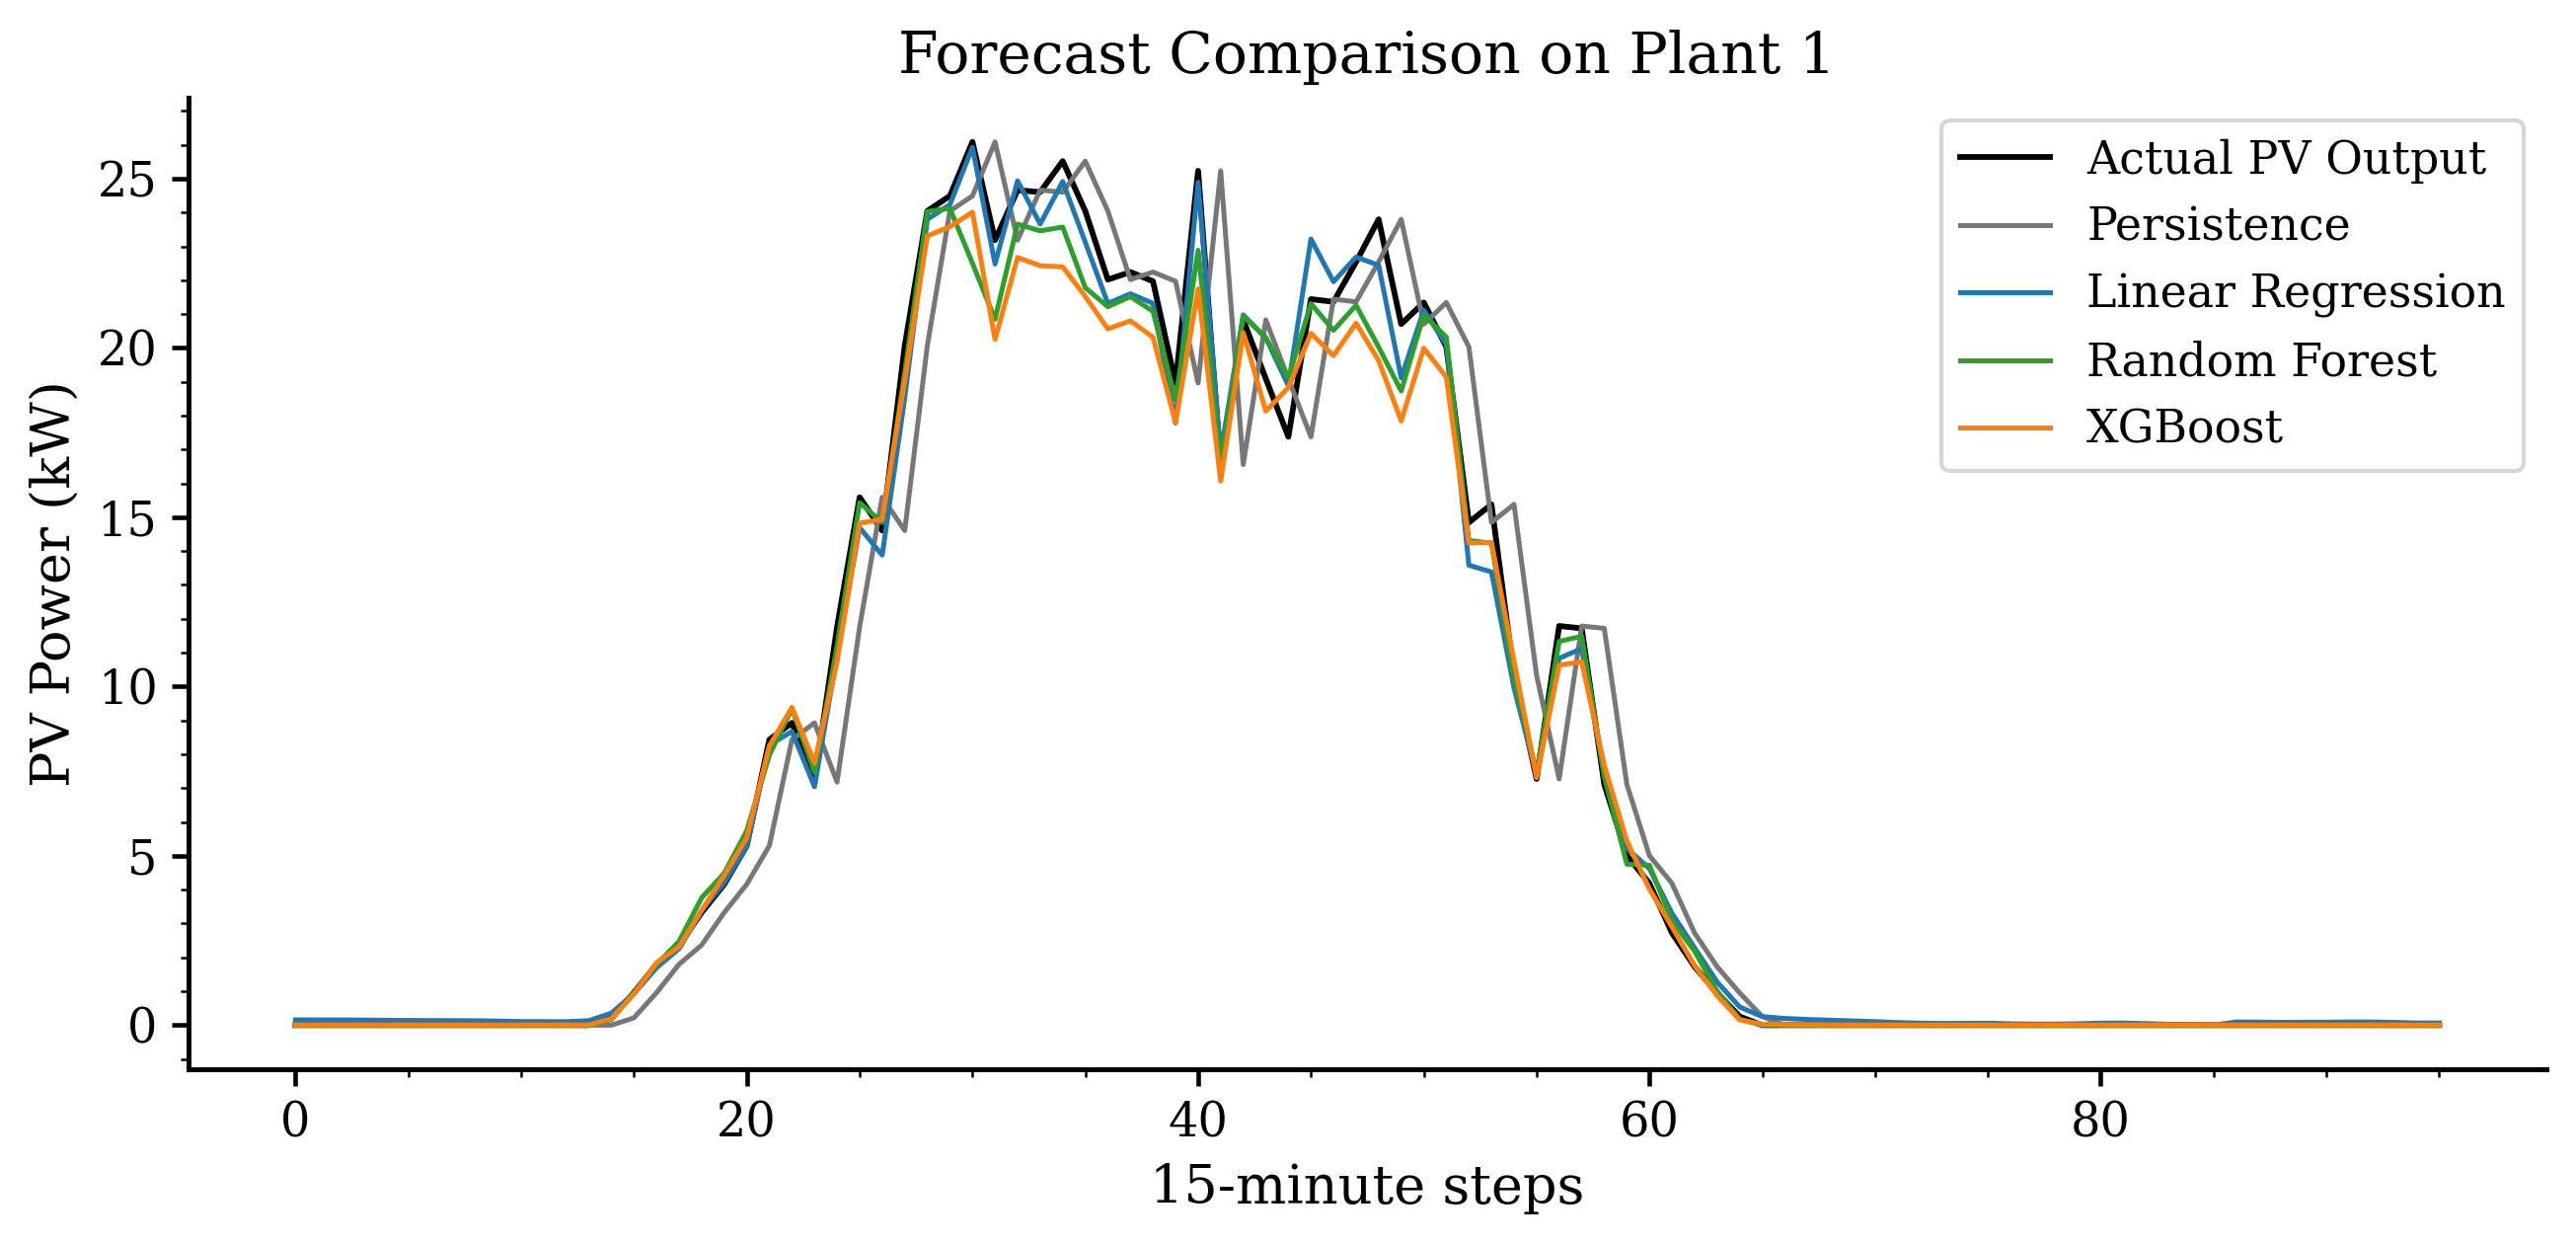

In [23]:
persist_full = data["pv_kw"].shift(1)
persist_slice = persist_full.loc[y_test.index[:96]].fillna(method="bfill").values

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "legend.fontsize": 11,
    "figure.dpi": 300,
})

def style_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.minorticks_on()
    ax.tick_params(direction="out", length=4, width=1.1)

N = 96
actual = y_test.values[:N]
lr_vals  = y_pred_lr[:N]
rf_vals  = y_pred_rf[:N]
xgb_vals = y_pred_xgb[:N]

fig, ax = plt.subplots(figsize=(8.8, 4.3))

ax.plot(actual,       label="Actual PV Output",  color="black",   lw=1.4)
ax.plot(persist_slice, label="Persistence",      color="#777777", lw=1.2)
ax.plot(lr_vals,      label="Linear Regression", color="#1f77b4", lw=1.2)
ax.plot(rf_vals,      label="Random Forest",     color="#2ca02c", lw=1.2)
ax.plot(xgb_vals,     label="XGBoost",           color="#ff7f0e", lw=1.2)

ax.set_ylabel("PV Power (kW)")
ax.set_xlabel("15-minute steps")
ax.set_title("Forecast Comparison on Plant 1")

ax.legend(frameon=True, facecolor="white")
style_axes(ax)

plt.tight_layout()
plt.show()

In [24]:
# Battery & System Parameters
DT_HOURS = 0.25
BATTERY_CAP_KWH = 10.0
MAX_CHARGE_KW = 3.0
MAX_DISCHARGE_KW = -3.0
ETA_CHARGE = 0.95
ETA_DISCHARGE = 0.95

def step_env(soc, action_kw, pv_kw, load_kw):
    action_kw = np.clip(action_kw, MAX_DISCHARGE_KW, MAX_CHARGE_KW)
    if action_kw >= 0:
        delta = (action_kw * ETA_CHARGE * DT_HOURS) / BATTERY_CAP_KWH
    else:
        delta = (action_kw / ETA_DISCHARGE * DT_HOURS) / BATTERY_CAP_KWH

    soc_next = np.clip(soc + delta, 0, 1)

    p_grid = load_kw - pv_kw + action_kw
    p_import = max(p_grid, 0)
    p_export = max(-p_grid, 0)

    reward = -(2*p_import - 0.5*p_export + 0.05*abs(action_kw))
    return soc_next, action_kw, p_import, reward

def rule_controller(soc, pv, load, hour):
    if pv > load + 0.3 and soc < 0.8 and 9 <= hour <= 15:
        return MAX_CHARGE_KW
    if load > pv + 0.3 and soc > 0.2 and (hour >= 18 or hour <= 7):
        return MAX_DISCHARGE_KW/2
    return 0.0

In [25]:
# Split Plant 1 control dataframe
split_idx = int(len(control_df_plant1) * 0.7)
train_ctrl = control_df_plant1.iloc[:split_idx].copy()
test_ctrl  = control_df_plant1.iloc[split_idx:].copy()

print("train_ctrl:", train_ctrl.shape, "| test_ctrl:", test_ctrl.shape)

train_ctrl: (2210, 7) | test_ctrl: (948, 7)


In [26]:
from collections import defaultdict

ACTIONS = np.array([MAX_DISCHARGE_KW, MAX_DISCHARGE_KW/2, 0, MAX_CHARGE_KW/2, MAX_CHARGE_KW])
ALPHA = 0.05
GAMMA = 0.98
EPS_END = 0.01
NUM_EPISODES = 200

def hour_group(h):
    if 6 <= h < 10: return 1
    if 10 <= h < 16: return 2
    if 16 <= h < 21: return 3
    return 0

def net_cond(pv, load):
    if pv > load + 0.3: return 0
    if load > pv + 0.3: return 1
    return 2

def encode_state_rl(soc, pv, load, hour):
    return (int(np.floor(soc*10)), hour_group(hour), net_cond(pv, load))

Q_rl = defaultdict(lambda: np.zeros(len(ACTIONS)))

for ep in range(NUM_EPISODES):
    eps = EPS_END + (1 - EPS_END) * (NUM_EPISODES-1-ep)/(NUM_EPISODES-1)
    soc, total_r = 0.5, 0

    for idx in range(len(train_ctrl)-1):
        r0, r1 = train_ctrl.iloc[idx], train_ctrl.iloc[idx+1]

        s = encode_state_rl(soc, r0.pv_kw, r0.load_kw, r0.hour)
        if np.random.rand() < eps:
            ai = np.random.randint(len(ACTIONS))
        else:
            ai = int(np.argmax(Q_rl[s]))

        soc_next, _, _, r = step_env(soc, ACTIONS[ai], r0.pv_kw, r0.load_kw)

        s2 = encode_state_rl(soc_next, r1.pv_kw, r1.load_kw, r1.hour)
        Q_rl[s][ai] += ALPHA*(r + GAMMA*np.max(Q_rl[s2]) - Q_rl[s][ai])

        soc = soc_next
        total_r += r

    if (ep+1) % 25 == 0:
        print(f"[RL-only] Ep {ep+1}/{NUM_EPISODES} | reward {total_r:.1f}")


[RL-only] Ep 25/200 | reward 1517.9
[RL-only] Ep 50/200 | reward 2462.1
[RL-only] Ep 75/200 | reward 3056.7
[RL-only] Ep 100/200 | reward 3966.8
[RL-only] Ep 125/200 | reward 4391.1
[RL-only] Ep 150/200 | reward 5224.1
[RL-only] Ep 175/200 | reward 6382.9
[RL-only] Ep 200/200 | reward 7889.2


In [27]:
from collections import defaultdict

rf_fast = RandomForestRegressor(
    n_estimators=60,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_fast.fit(X_train, y_train)

xgb_fast = XGBRegressor(
    n_estimators=80,
    max_depth=4,
    learning_rate=0.07,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_fast.fit(X_train, y_train)

# Forecast cache for faster training
def build_forecast_cache(model, df):
    cache = []
    for idx in range(len(df)):
        Xf = df.iloc[idx][["IRRADIATION","AMBIENT_TEMPERATURE",
                           "MODULE_TEMPERATURE","hour","day_of_year"]]
        pred = float(np.clip(model.predict(Xf.to_frame().T)[0], 0, 5))
        cache.append(pred)
    return cache

cache_lr  = build_forecast_cache(lr_model,  train_ctrl)
cache_rf  = build_forecast_cache(rf_fast,   train_ctrl)
cache_xgb = build_forecast_cache(xgb_fast,  train_ctrl)


# Hybrid state encoder
def encode_state_hybrid(soc, pv, load, hour, forecast_kw):
    soc_bin = int(np.clip(np.floor(soc*10), 0, 9))
    fb = int(np.clip(np.floor((forecast_kw/5.0)*4), 0, 3))
    return (soc_bin, hour_group(hour), net_cond(pv, load), fb)


def train_hybrid_fast(f_cache, model_name):
    Q = defaultdict(lambda: np.zeros(len(ACTIONS)))
    EPISODES = 40

    for ep in range(EPISODES):
        eps = EPS_END + (1 - EPS_END) * (EPISODES-1-ep)/(EPISODES-1)
        soc, total_r = 0.5, 0

        for idx in range(len(train_ctrl)-1):
            r0, r1 = train_ctrl.iloc[idx], train_ctrl.iloc[idx+1]

            f0 = f_cache[idx]
            f1 = f_cache[idx+1]

            s = encode_state_hybrid(soc, r0.pv_kw, r0.load_kw, r0.hour, f0)

            # epsilon-greedy
            if np.random.rand() < eps:
                ai = np.random.randint(len(ACTIONS))
            else:
                ai = int(np.argmax(Q[s]))

            soc_n, _, _, r = step_env(soc, ACTIONS[ai], r0.pv_kw, r0.load_kw)

            s2 = encode_state_hybrid(soc_n, r1.pv_kw, r1.load_kw, r1.hour, f1)

            Q[s][ai] += ALPHA * (r + GAMMA*np.max(Q[s2]) - Q[s][ai])

            soc, total_r = soc_n, total_r + r

        if (ep+1) % 10 == 0:
            print(f"[Hybrid {model_name}] {ep+1}/{EPISODES} | reward {total_r:.1f}")

    return Q


Q_hyb_lr  = train_hybrid_fast(cache_lr,  "LR")
Q_hyb_rf  = train_hybrid_fast(cache_rf,  "RF")
Q_hyb_xgb = train_hybrid_fast(cache_xgb, "XGB")

[Hybrid LR] 10/40 | reward 2511.5
[Hybrid LR] 20/40 | reward 3706.6
[Hybrid LR] 30/40 | reward 5728.8
[Hybrid LR] 40/40 | reward 7563.3
[Hybrid RF] 10/40 | reward 2367.1
[Hybrid RF] 20/40 | reward 3635.5
[Hybrid RF] 30/40 | reward 5743.0
[Hybrid RF] 40/40 | reward 7747.0
[Hybrid XGB] 10/40 | reward 2191.2
[Hybrid XGB] 20/40 | reward 3459.7
[Hybrid XGB] 30/40 | reward 5586.7
[Hybrid XGB] 40/40 | reward 7508.1


In [28]:
def simulate(df, controller_fn):
    soc = 0.5
    imports, cycles = 0.0, 0.0
    for _, row in df.iterrows():
        pv, load = row.pv_kw, row.load_kw
        hour = row.hour
        act = controller_fn(soc, pv, load, hour)
        soc_next, batt, imp, _ = step_env(soc, act, pv, load)
        imports += imp * DT_HOURS
        cycles  += abs(batt) * DT_HOURS
        soc = soc_next
    return imports, cycles

def rl_policy(soc, pv, load, hour):
    s = encode_state_rl(soc, pv, load, hour)
    return ACTIONS[int(np.argmax(Q_rl[s]))]

def hybrid_policy_from_Q(Qmap, forecaster):
    def policy(soc, pv, load, hour):
        X = pd.Series([pv, load, 0, hour, 0])
        return 0
    def policy_fn(soc, pv, load, hour, forecast_kw):
        state = encode_state_hybrid(soc, pv, load, hour, forecast_kw)
        return ACTIONS[int(np.argmax(Qmap[state]))]
    return policy_fn

# Evaluate Rule-based
m_rule = simulate(test_ctrl, rule_controller)

# RL-only
m_rl = simulate(test_ctrl, rl_policy)

# Hybrids
def sim_hybrid(df, Qmap, model):
    soc = 0.5
    imports, cycles = 0.0, 0.0
    for _, row in df.iterrows():
        X = row[["IRRADIATION","AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","hour","day_of_year"]]
        fkw = float(np.clip(model.predict(X.to_frame().T)[0], 0, 5))
        act = ACTIONS[int(np.argmax(Qmap[ encode_state_hybrid(soc, row.pv_kw, row.load_kw, row.hour, fkw) ]))]
        soc_next, batt, imp, _ = step_env(soc, act, row.pv_kw, row.load_kw)
        imports += imp * DT_HOURS
        cycles  += abs(batt) * DT_HOURS
        soc = soc_next
    return imports, cycles

m_hyb_lr  = sim_hybrid(test_ctrl, Q_hyb_lr,  lr_model)
m_hyb_rf  = sim_hybrid(test_ctrl, Q_hyb_rf,  rf_model)
m_hyb_xgb = sim_hybrid(test_ctrl, Q_hyb_xgb, xgb_model)

print("==Control Performance on Plant 1")
print("Rule-based     :", m_rule)
print("RL-only        :", m_rl)
print("Hybrid (LR)    :", m_hyb_lr)
print("Hybrid (RF)    :", m_hyb_rf)
print("Hybrid (XGB)   :", m_hyb_xgb)

==Control Performance on Plant 1
Rule-based     : (np.float64(188.40575063271422), np.float64(131.625))
RL-only        : (np.float64(15.918064439400622), np.float64(697.5))
Hybrid (LR)    : (np.float64(10.972767388873516), np.float64(701.25))
Hybrid (RF)    : (np.float64(14.528350792956536), np.float64(694.875))
Hybrid (XGB)   : (np.float64(10.13141351177096), np.float64(616.5))


,Controller,GridImport_kWh,EqFullCycles
0,Rule-based,188.405751,131.625
1,RL-only,15.918064,697.500
2,Hybrid LR,10.972767,701.250
3,Hybrid RF,14.528351,694.875
4,Hybrid XGB,10.131414,616.500


/tmp/ipython-input-2247147603.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(controllers, rotation=20, ha="right")


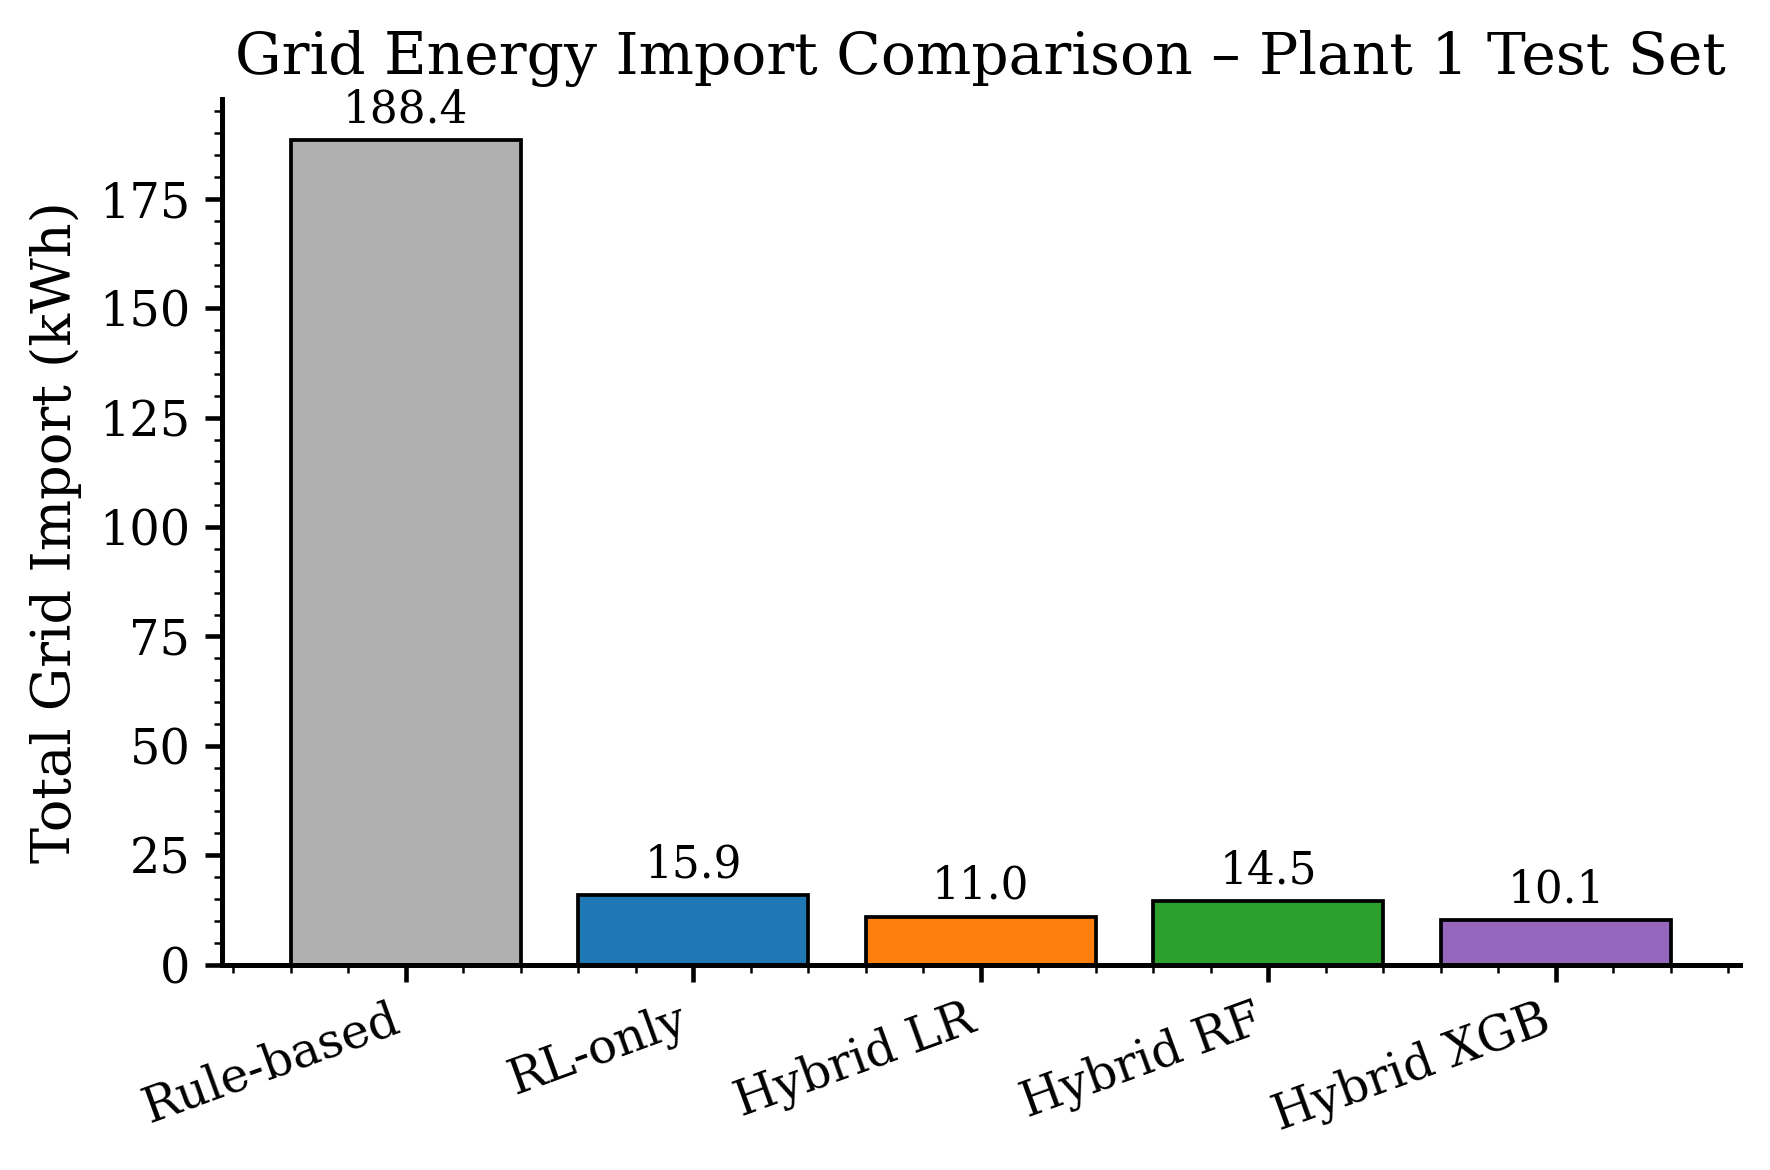

/tmp/ipython-input-2247147603.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(controllers, rotation=20, ha="right")


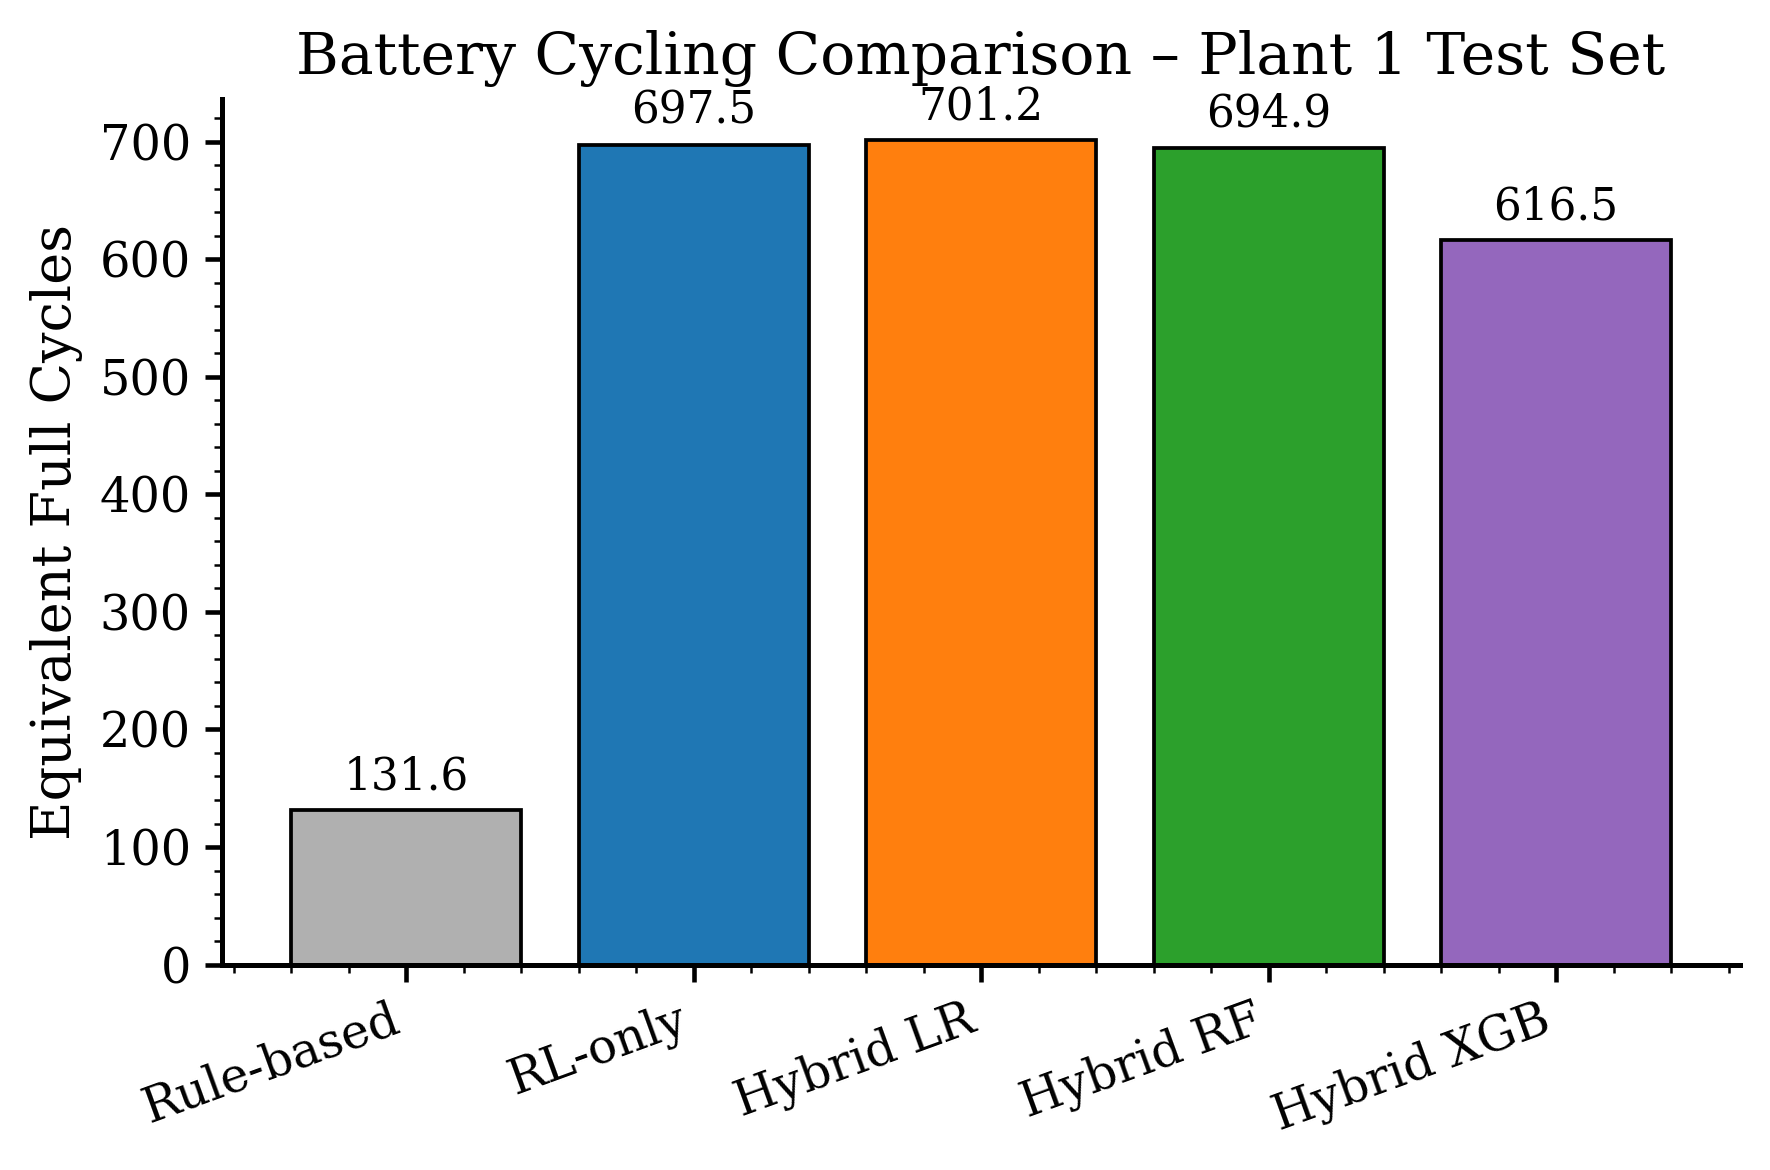

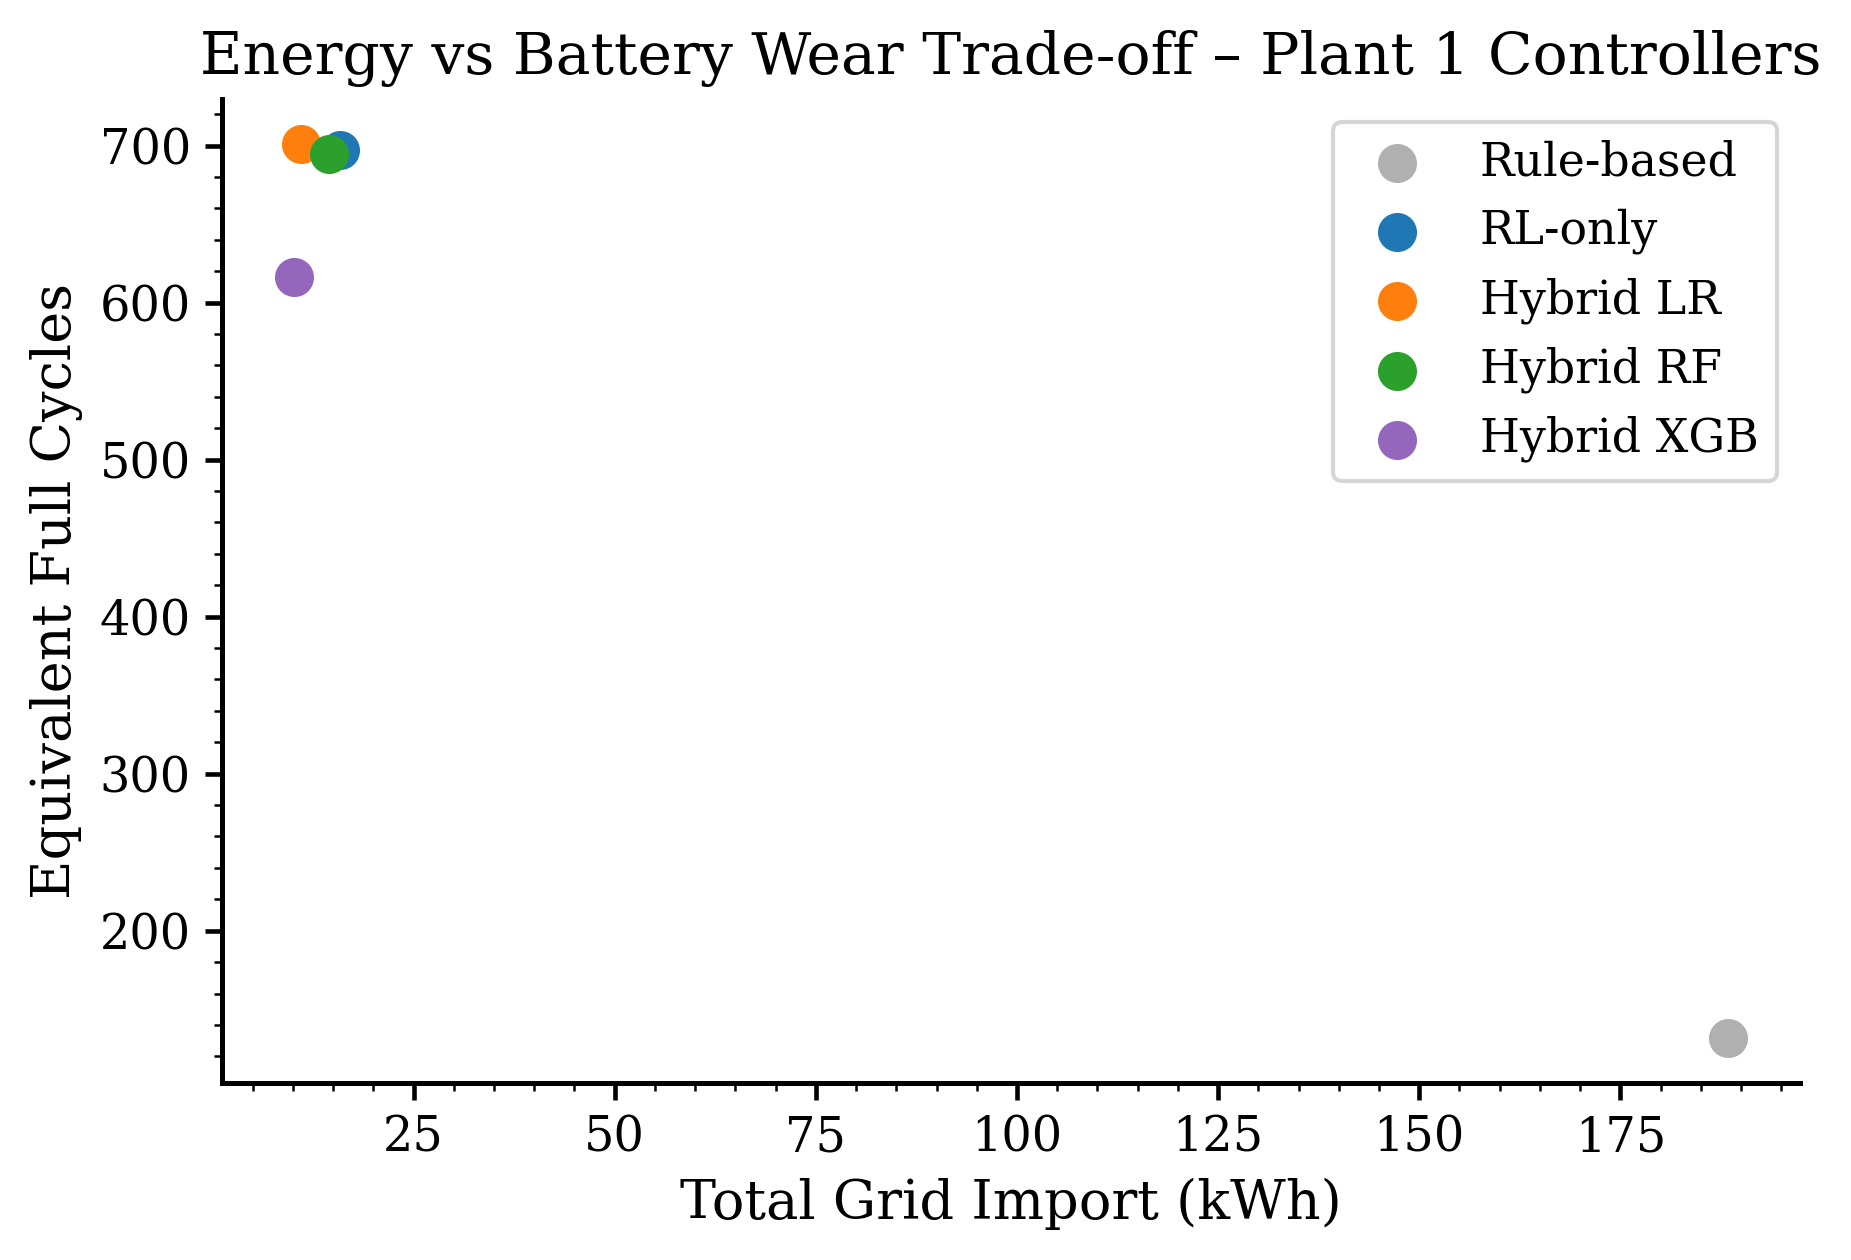

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "legend.fontsize": 11,
    "figure.dpi": 300,
})

def style_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.minorticks_on()
    ax.tick_params(direction="out", length=4, width=1.1)

controllers = ["Rule-based", "RL-only", "Hybrid LR", "Hybrid RF", "Hybrid XGB"]

grid_imports = [
    float(m_rule[0]),
    float(m_rl[0]),
    float(m_hyb_lr[0]),
    float(m_hyb_rf[0]),
    float(m_hyb_xgb[0]),
]

cycles = [
    float(m_rule[1]),
    float(m_rl[1]),
    float(m_hyb_lr[1]),
    float(m_hyb_rf[1]),
    float(m_hyb_xgb[1]),
]

perf_df = pd.DataFrame({
    "Controller": controllers,
    "GridImport_kWh": grid_imports,
    "EqFullCycles": cycles,
})
display(perf_df)

colors = ["#B0B0B0", "#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(controllers, grid_imports, color=colors, edgecolor="black", linewidth=0.9)
ax.set_ylabel("Total Grid Import (kWh)")
ax.set_title("Grid Energy Import Comparison – Plant 1 Test Set")
for b in bars:
    h = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, h + 2, f"{h:.1f}", ha="center", va="bottom", fontsize=10.5)
ax.set_xticklabels(controllers, rotation=20, ha="right")
style_axes(ax)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
bars2 = ax.bar(controllers, cycles, color=colors, edgecolor="black", linewidth=0.9)
ax.set_ylabel("Equivalent Full Cycles")
ax.set_title("Battery Cycling Comparison – Plant 1 Test Set")
for b in bars2:
    h = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, h + 10, f"{h:.1f}", ha="center", va="bottom", fontsize=10.5)
ax.set_xticklabels(controllers, rotation=20, ha="right")
style_axes(ax)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6.2,4.3))

colors = {
    "Rule-based": "#B0B0B0",
    "RL-only": "#1f77b4",
    "Hybrid LR": "#ff7f0e",
    "Hybrid RF": "#2ca02c",
    "Hybrid XGB": "#9467bd"
}

for name, gi, cyc in zip(controllers, grid_imports, cycles):
    ax.scatter(gi, cyc, color=colors[name], s=70, label=name)

ax.set_xlabel("Total Grid Import (kWh)")
ax.set_ylabel("Equivalent Full Cycles")
ax.set_title("Energy vs Battery Wear Trade-off – Plant 1 Controllers")

handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), frameon=True, facecolor="white", loc="best")

style_axes(ax)
plt.tight_layout()
plt.show()

In [30]:
feature_cols_no_time = ["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]
X_no_time = data[feature_cols_no_time]
X_train_nt = X_no_time.iloc[:split_idx]
X_test_nt  = X_no_time.iloc[split_idx:]

lr_no_time = LinearRegression()
lr_no_time.fit(X_train_nt, y_train)

from collections import defaultdict

def build_cache_no_time(model, df):
    cache = []
    for idx in range(len(df)):
        Xf = df.iloc[idx][["IRRADIATION","AMBIENT_TEMPERATURE","MODULE_TEMPERATURE"]]
        pred = float(np.clip(model.predict(Xf.to_frame().T)[0], 0, 5))
        cache.append(pred)
    return cache

cache_lr_nt = build_cache_no_time(lr_no_time, train_ctrl)

def train_hybrid_fast_generic(cache, model_name):
    Q = defaultdict(lambda: np.zeros(len(ACTIONS)))
    EPISODES = 40
    for ep in range(EPISODES):
        eps = EPS_END + (1 - EPS_END) * (EPISODES-1-ep)/(EPISODES-1)
        soc, total_r = 0.5, 0
        for idx in range(len(train_ctrl)-1):
            r0, r1 = train_ctrl.iloc[idx], train_ctrl.iloc[idx+1]
            f0 = cache[idx]
            f1 = cache[idx+1]
            s  = encode_state_hybrid(soc, r0.pv_kw, r0.load_kw, r0.hour, f0)
            if np.random.rand() < eps:
                ai = np.random.randint(len(ACTIONS))
            else:
                ai = int(np.argmax(Q[s]))
            soc_n, _, _, r = step_env(soc, ACTIONS[ai], r0.pv_kw, r0.load_kw)
            s2 = encode_state_hybrid(soc_n, r1.pv_kw, r1.load_kw, r1.hour, f1)
            Q[s][ai] += ALPHA * (r + GAMMA*np.max(Q[s2]) - Q[s][ai])
            soc, total_r = soc_n, total_r + r
        if (ep+1) % 10 == 0:
            print(f"[Hybrid {model_name}] {ep+1}/{EPISODES} | reward {total_r:.1f}")
    return Q

Q_hyb_lr_nt = train_hybrid_fast_generic(cache_lr_nt, "LR (no time)")

def sim_hybrid_no_time(df, Qmap, model):
    soc = 0.5
    imports, cycles = 0.0, 0.0
    for _, row in df.iterrows():
        Xf = row[["IRRADIATION","AMBIENT_TEMPERATURE","MODULE_TEMPERATURE"]]
        fkw = float(np.clip(model.predict(Xf.to_frame().T)[0], 0, 5))
        act = ACTIONS[int(np.argmax(Qmap[encode_state_hybrid(soc, row.pv_kw, row.load_kw, row.hour, fkw)]) )]
        soc_n, batt, imp, _ = step_env(soc, act, row.pv_kw, row.load_kw)
        imports += imp * DT_HOURS
        cycles  += abs(batt) * DT_HOURS
        soc = soc_n
    return imports, cycles

m_hyb_lr_nt = sim_hybrid_no_time(test_ctrl, Q_hyb_lr_nt, lr_no_time)

print("Hybrid LR (full features):", m_hyb_lr)
print("Hybrid LR (no time info) :", m_hyb_lr_nt)

[Hybrid LR (no time)] 10/40 | reward 1924.0
[Hybrid LR (no time)] 20/40 | reward 3865.7
[Hybrid LR (no time)] 30/40 | reward 5375.6
[Hybrid LR (no time)] 40/40 | reward 7873.2
Hybrid LR (full features): (np.float64(10.972767388873516), np.float64(701.25))
Hybrid LR (no time info) : (np.float64(10.13141351177096), np.float64(705.75))


In [31]:
def step_env_no_soc(soc, action_kw, pv_kw, load_kw):
    action_kw = np.clip(action_kw, MAX_DISCHARGE_KW, MAX_CHARGE_KW)
    if action_kw >= 0:
        delta = (action_kw * ETA_CHARGE * DT_HOURS) / BATTERY_CAP_KWH
    else:
        delta = (action_kw / ETA_DISCHARGE * DT_HOURS) / BATTERY_CAP_KWH
    soc_next = np.clip(soc + delta, 0, 1)
    p_grid = load_kw - pv_kw + action_kw
    p_import = max(p_grid, 0)
    p_export = max(-p_grid, 0)
    reward = -(2*p_import - 0.5*p_export + 0.05*abs(action_kw))
    return soc_next, action_kw, p_import, reward

Q_rl_nosoc = defaultdict(lambda: np.zeros(len(ACTIONS)))
EPISODES = 120

for ep in range(EPISODES):
    eps = EPS_END + (1 - EPS_END) * (EPISODES-1-ep)/(EPISODES-1)
    soc, total_r = 0.5, 0
    for idx in range(len(train_ctrl)-1):
        r0, r1 = train_ctrl.iloc[idx], train_ctrl.iloc[idx+1]
        s = encode_state_rl(soc, r0.pv_kw, r0.load_kw, r0.hour)
        if np.random.rand() < eps:
            ai = np.random.randint(len(ACTIONS))
        else:
            ai = int(np.argmax(Q_rl_nosoc[s]))
        soc_next, _, _, r = step_env_no_soc(soc, ACTIONS[ai], r0.pv_kw, r0.load_kw)
        s2 = encode_state_rl(soc_next, r1.pv_kw, r1.load_kw, r1.hour)
        Q_rl_nosoc[s][ai] += ALPHA*(r + GAMMA*np.max(Q_rl_nosoc[s2]) - Q_rl_nosoc[s][ai])
        soc, total_r = soc_next, total_r + r
    if (ep+1) % 30 == 0:
        print(f"[RL-no-SoC] {ep+1}/{EPISODES} | reward {total_r:.1f}")

def rl_nosoc_policy(soc, pv, load, hour):
    s = encode_state_rl(soc, pv, load, hour)
    return ACTIONS[int(np.argmax(Q_rl_nosoc[s]))]

m_rl_nosoc = simulate(test_ctrl, rl_nosoc_policy)

print("RL-only (original reward):", m_rl)
print("RL-only (no SoC term)   :", m_rl_nosoc)

[RL-no-SoC] 30/120 | reward 2170.5
[RL-no-SoC] 60/120 | reward 3920.0
[RL-no-SoC] 90/120 | reward 5056.4
[RL-no-SoC] 120/120 | reward 6800.3
RL-only (original reward): (np.float64(15.918064439400622), np.float64(697.5))
RL-only (no SoC term)   : (np.float64(14.94372376567023), np.float64(542.625))


In [32]:
def sim_hybrid_noisy(df, Qmap, model, noise_level, seed=123):
    rng = np.random.default_rng(seed)
    soc = 0.5
    imports, cycles = 0.0, 0.0
    for _, row in df.iterrows():
        Xf = row[["IRRADIATION","AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","hour","day_of_year"]]
        base_fk = float(np.clip(model.predict(Xf.to_frame().T)[0], 0, 5))
        noise_factor = 1.0 + rng.uniform(-noise_level, noise_level)
        fkw = np.clip(base_fk * noise_factor, 0, 5)
        act = ACTIONS[int(np.argmax(Qmap[encode_state_hybrid(soc, row.pv_kw, row.load_kw, row.hour, fkw)]) )]
        soc_n, batt, imp, _ = step_env(soc, act, row.pv_kw, row.load_kw)
        imports += imp * DT_HOURS
        cycles  += abs(batt) * DT_HOURS
        soc = soc_n
    return imports, cycles

noise_levels = [0.0, 0.1, 0.2, 0.3]
imports_list = []
cycles_list = []

for nl in noise_levels:
    gi, cyc = sim_hybrid_noisy(test_ctrl, Q_hyb_xgb, xgb_model, nl)
    imports_list.append(gi)
    cycles_list.append(cyc)
    print(f"Noise {int(nl*100)}% -> Import={gi:.2f} kWh, Cycles={cyc:.1f}")


Noise 0% -> Import=10.13 kWh, Cycles=616.5
Noise 10% -> Import=10.13 kWh, Cycles=617.2
Noise 20% -> Import=10.13 kWh, Cycles=617.2
Noise 30% -> Import=10.13 kWh, Cycles=606.0


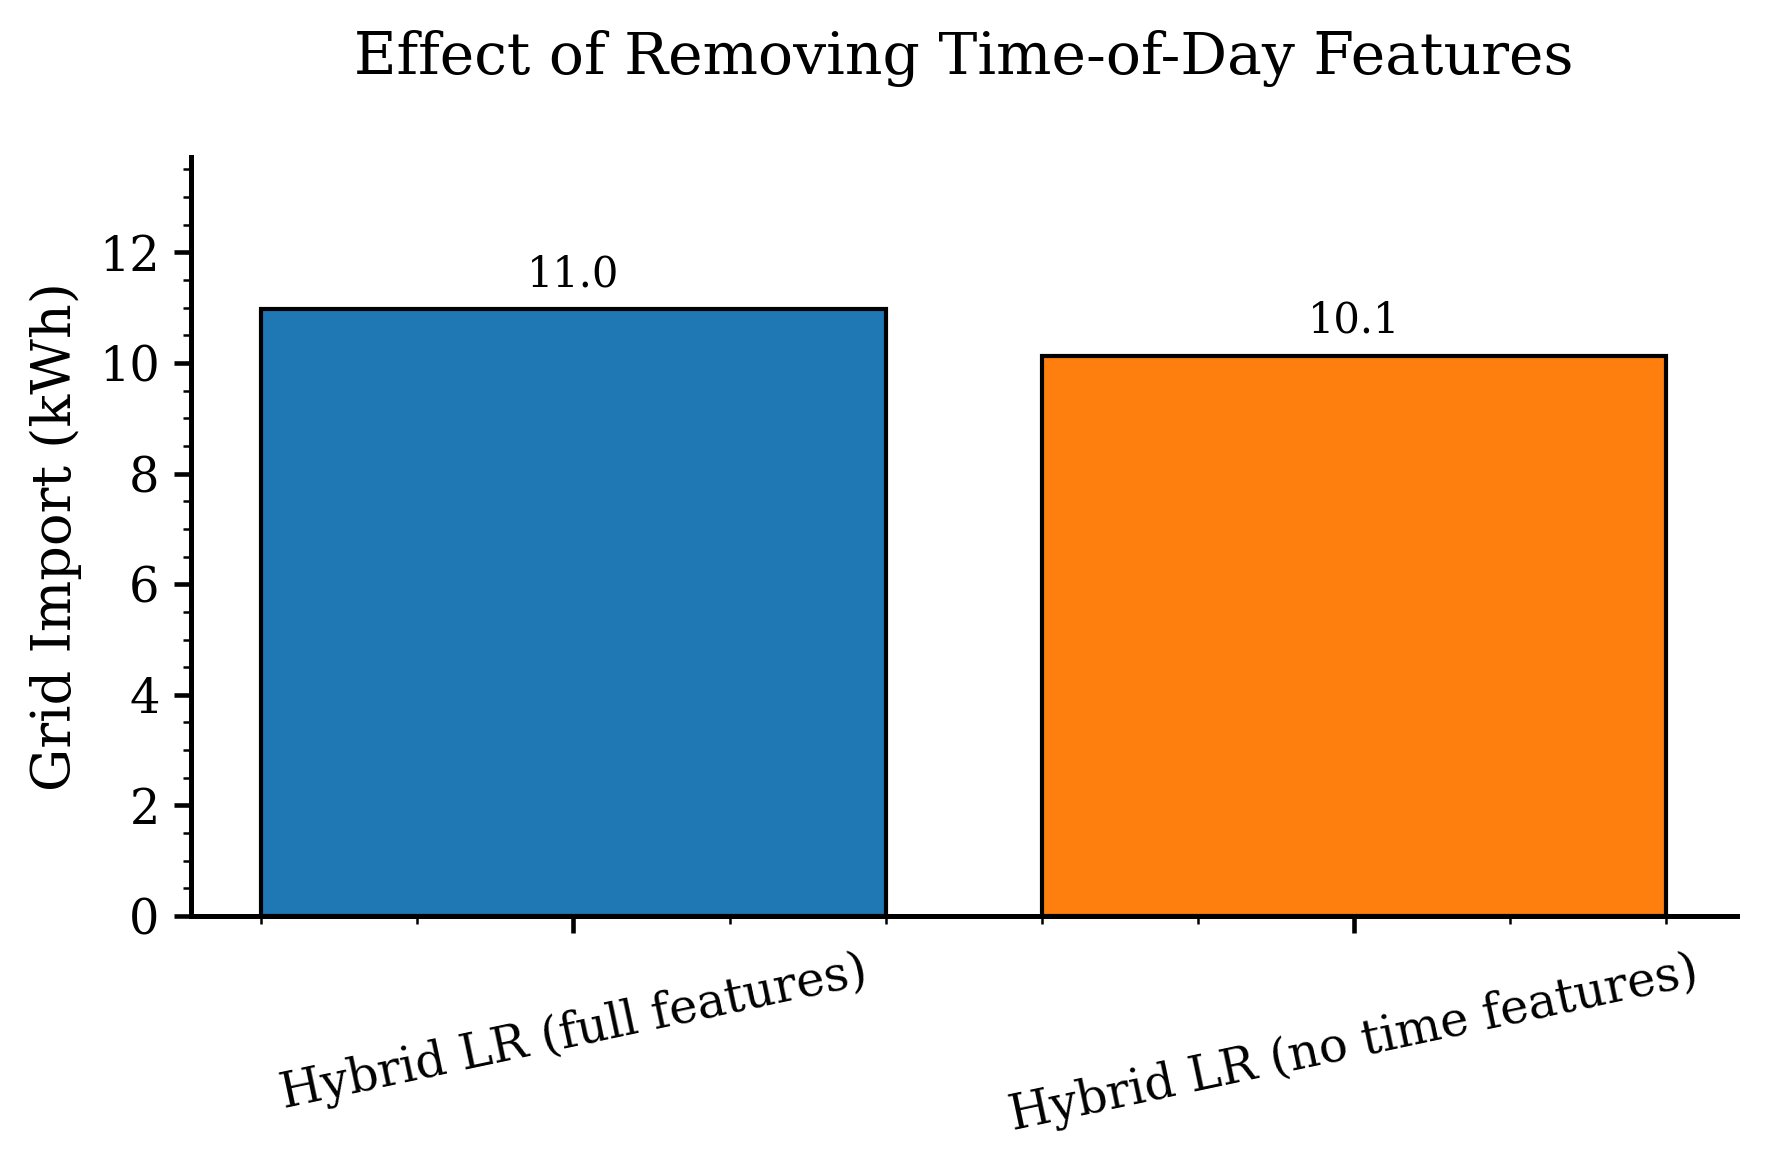

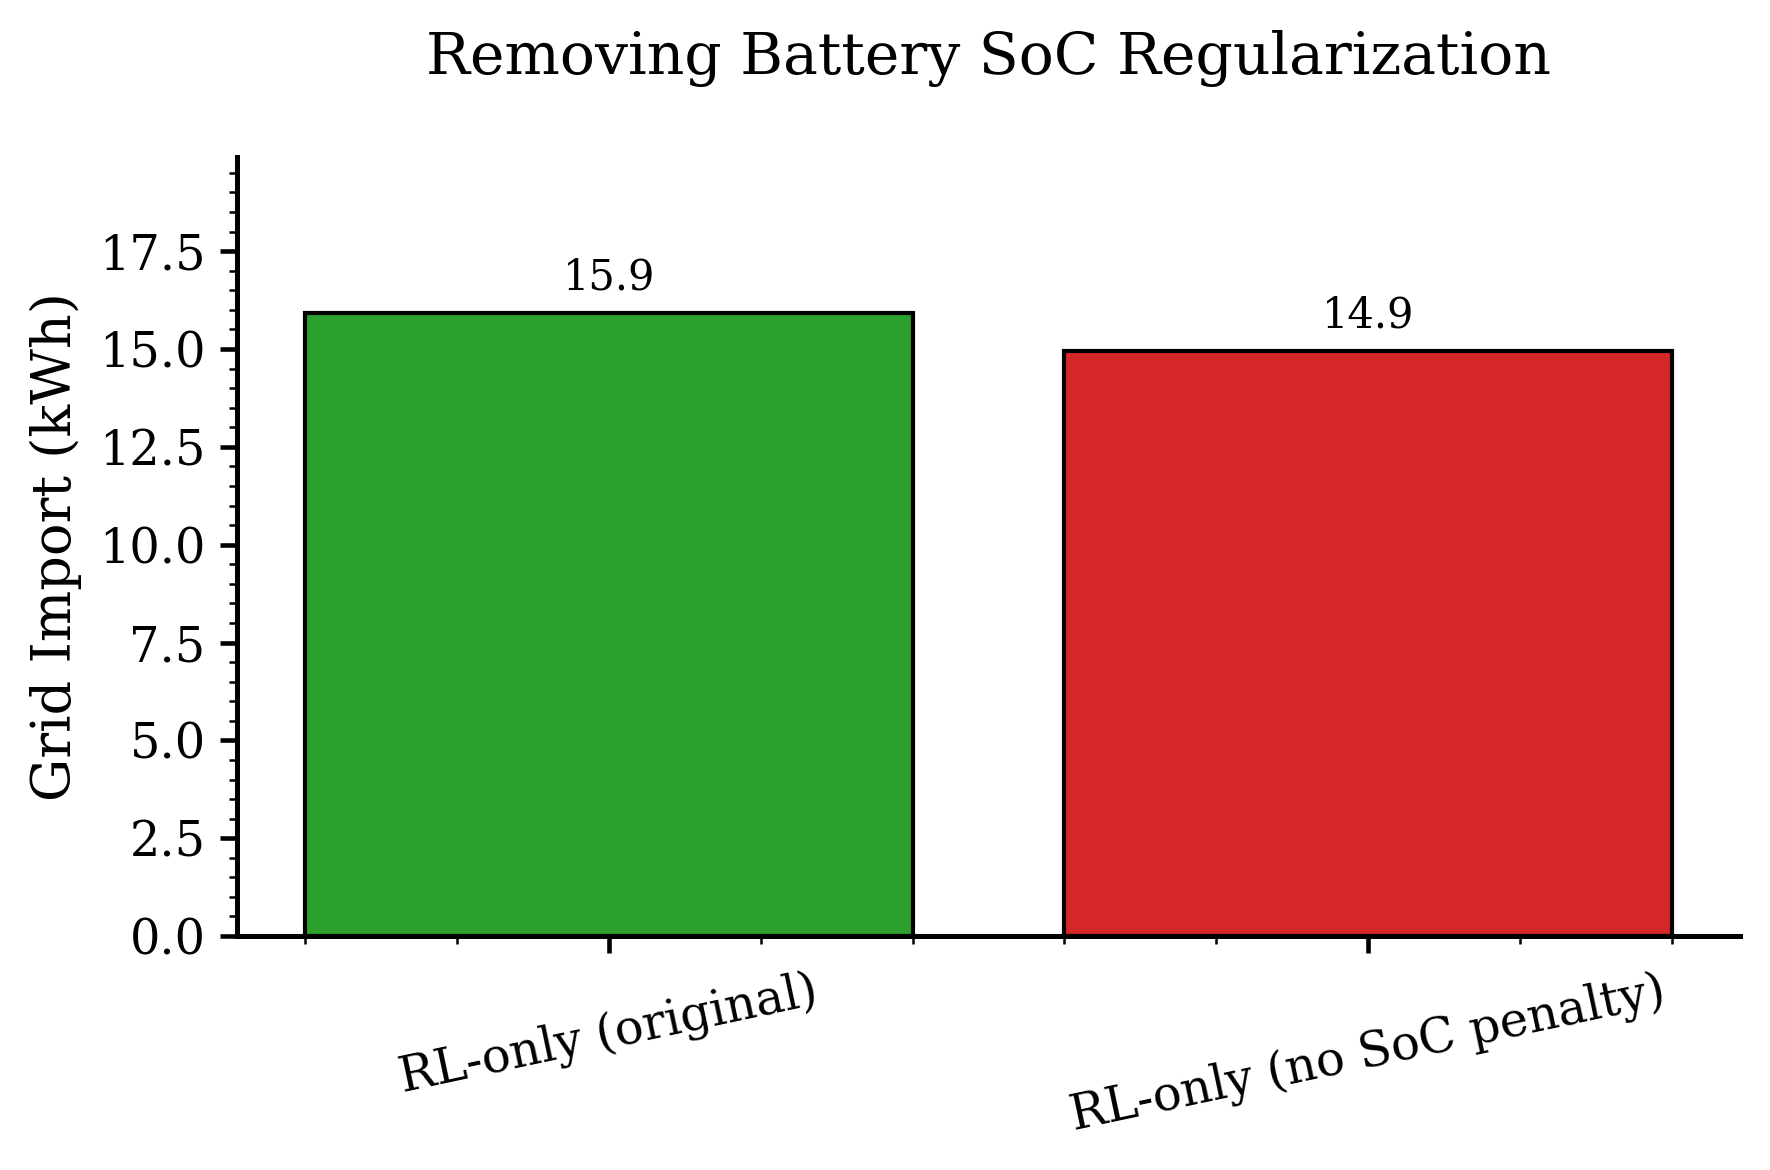

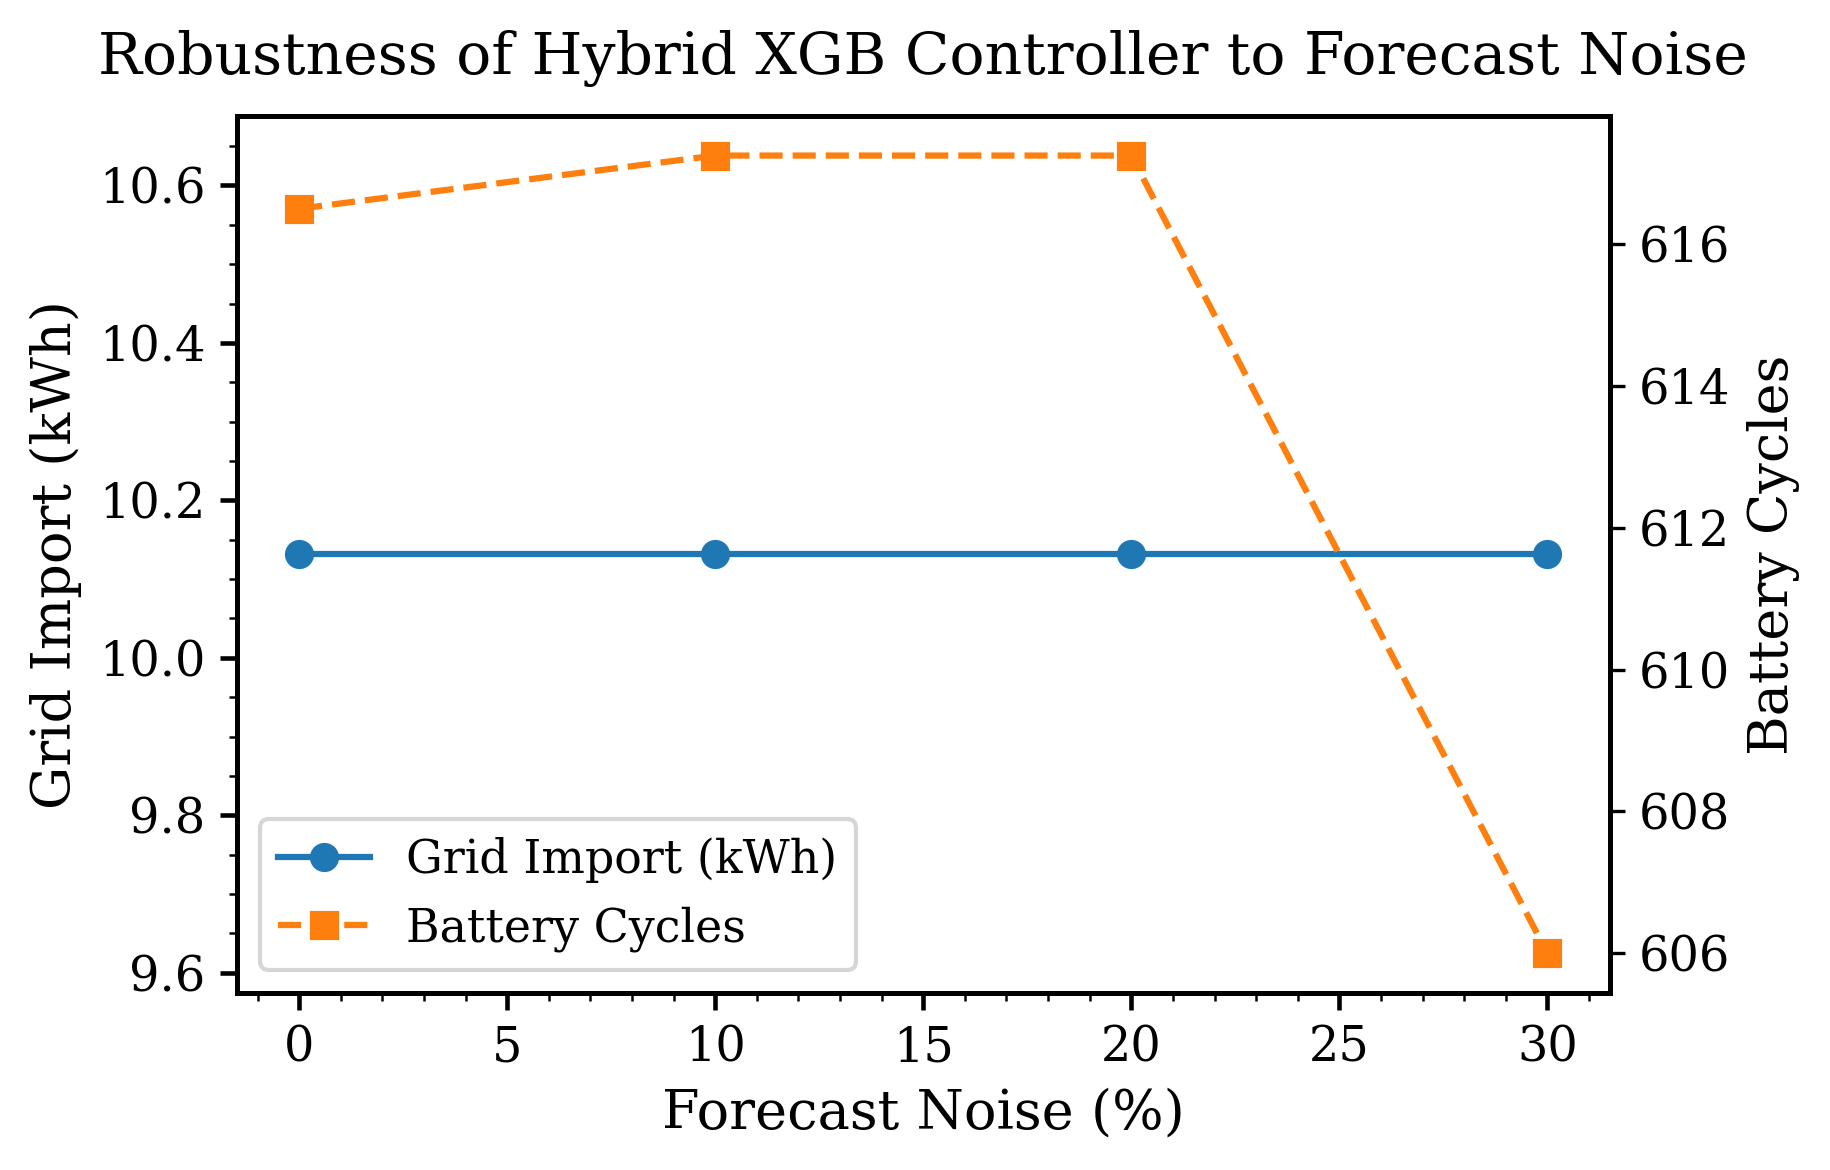

In [37]:
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "legend.fontsize": 11,
    "figure.dpi": 300,
})

def style_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.minorticks_on()
    ax.tick_params(direction="out", length=4, width=1.1)


# 1. Feature Ablation
vals = [float(m_hyb_lr[0]), float(m_hyb_lr_nt[0])]
labels = ["Hybrid LR (full features)", "Hybrid LR (no time features)"]
colors = ["#1f77b4", "#ff7f0e"]

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(labels, vals, color=colors, edgecolor="black")

ymax = max(vals) * 1.25
ax.set_ylim(0, ymax)

ax.set_ylabel("Grid Import (kWh)")
ax.set_title("Effect of Removing Time-of-Day Features", pad=20)

for b in bars:
    h = b.get_height()
    ax.text(b.get_x()+b.get_width()/2,
            h + ymax*0.03,
            f"{h:.1f}",
            ha="center")

plt.xticks(rotation=12)
style_axes(ax)
plt.tight_layout()
plt.show()


# 2. SoC Penalty Ablation
vals_soc = [float(m_rl[0]), float(m_rl_nosoc[0])]
labels_soc = ["RL-only (original)", "RL-only (no SoC penalty)"]
colors_soc = ["#2ca02c", "#d62728"]

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(labels_soc, vals_soc, color=colors_soc, edgecolor="black")

ymax = max(vals_soc) * 1.25
ax.set_ylim(0, ymax)

ax.set_ylabel("Grid Import (kWh)")
ax.set_title("Removing Battery SoC Regularization", pad=20)

for b in bars:
    h = b.get_height()
    ax.text(b.get_x()+b.get_width()/2,
            h + ymax*0.03,
            f"{h:.1f}",
            ha="center")

plt.xticks(rotation=12)
style_axes(ax)
plt.tight_layout()
plt.show()

# 3. Robustness Plot

noise_percent = [n*100 for n in noise_levels]

fig, ax1 = plt.subplots(figsize=(6.2,4))
ax1.plot(noise_percent, imports_list, marker="o", lw=1.5, label="Grid Import (kWh)")
ax1.set_xlabel("Forecast Noise (%)")
ax1.set_ylabel("Grid Import (kWh)")
style_axes(ax1)

ax2 = ax1.twinx()
ax2.plot(noise_percent, cycles_list, marker="s", lw=1.5, ls="--",
         color="#ff7f0e", label="Battery Cycles")
ax2.set_ylabel("Battery Cycles")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2,
           labels1 + labels2,
           frameon=True,
           facecolor="white",
           loc="lower left")

ax1.set_title("Robustness of Hybrid XGB Controller to Forecast Noise", pad=10)
plt.tight_layout()
plt.show()

In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

gen_p2 = pd.read_csv("Plant_2_Generation_Data.csv")
weather_p2 = pd.read_csv("Plant_2_Weather_Sensor_Data.csv")

gen_p2["DATE_TIME"] = pd.to_datetime(gen_p2["DATE_TIME"])
weather_p2["DATE_TIME"] = pd.to_datetime(weather_p2["DATE_TIME"])

gen_p2_agg = (
    gen_p2
    .groupby("DATE_TIME")[["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD"]]
    .sum()
    .sort_index()
)

weather_p2 = weather_p2.sort_values("DATE_TIME")

merged_p2 = pd.merge_asof(
    gen_p2_agg.reset_index().sort_values("DATE_TIME"),
    weather_p2[["DATE_TIME", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]],
    on="DATE_TIME"
)

merged_p2 = merged_p2.dropna().reset_index(drop=True)

merged_p2 = merged_p2.set_index("DATE_TIME").sort_index()
merged_p2 = merged_p2.resample("15T").agg({
    "DC_POWER": "sum",
    "AC_POWER": "sum",
    "DAILY_YIELD": "max",
    "TOTAL_YIELD": "max",
    "IRRADIATION": "mean",
    "AMBIENT_TEMPERATURE": "mean",
    "MODULE_TEMPERATURE": "mean"
}).dropna().reset_index()

merged_p2["hour"] = merged_p2["DATE_TIME"].dt.hour
merged_p2["day_of_year"] = merged_p2["DATE_TIME"].dt.dayofyear
merged_p2["pv_kw"] = merged_p2["AC_POWER"] / 1000.0

np.random.seed(42)
h = merged_p2["hour"].values
morning = np.exp(-0.5 * ((h - 8) / 2)**2)
evening = np.exp(-0.5 * ((h - 19) / 2)**2)
load_shape = 0.6 + morning + 1.2 * evening

merged_p2["load_kw"] = 2.0 * load_shape + 0.2 * np.random.randn(len(merged_p2))
merged_p2["load_kw"] = merged_p2["load_kw"].clip(lower=0.3)

control_df_plant2 = merged_p2.set_index("DATE_TIME")[[
    "pv_kw",
    "load_kw",
    "IRRADIATION",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "hour",
    "day_of_year"
]].copy()

print("Plant 2 control_df shape:", control_df_plant2.shape)
display(control_df_plant2.head(10))

data2 = control_df_plant2.sort_index()
feature_cols = ["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "hour", "day_of_year"]
X2 = data2[feature_cols]
y2 = data2["pv_kw"]

split_idx2 = int(len(data2) * 0.7)
X2_train, X2_test = X2.iloc[:split_idx2], X2.iloc[split_idx2:]
y2_train, y2_test = y2.iloc[:split_idx2], y2.iloc[split_idx2:]

print("Plant 2 Train:", X2_train.shape, "Test:", X2_test.shape)

lr_p2 = LinearRegression().fit(X2_train, y2_train)
pred_lr_p2 = lr_p2.predict(X2_test)

rf_p2 = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1).fit(X2_train, y2_train)
pred_rf_p2 = rf_p2.predict(X2_test)

xgb_p2 = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
).fit(X2_train, y2_train)
pred_xgb_p2 = xgb_p2.predict(X2_test)

print("\n---Plant 2 Forecasting")
print("LR     :", mean_absolute_error(y2_test, pred_lr_p2), r2_score(y2_test, pred_lr_p2))
print("RF     :", mean_absolute_error(y2_test, pred_rf_p2), r2_score(y2_test, pred_rf_p2))
print("XGB    :", mean_absolute_error(y2_test, pred_xgb_p2), r2_score(y2_test, pred_xgb_p2))

test_ctrl_p2 = control_df_plant2.iloc[split_idx2:].copy()

def simulate_for_Qmap(df, Qmap, model):
    soc = 0.5
    imports = 0.0
    cycles = 0.0
    for _, row in df.iterrows():
        Xf = row[["IRRADIATION","AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","hour","day_of_year"]]
        fkw = float(np.clip(model.predict(Xf.to_frame().T)[0], 0, 5))
        act = ACTIONS[int(np.argmax(Qmap[ encode_state_hybrid(soc, row.pv_kw, row.load_kw, row.hour, fkw) ]))]
        soc_n, batt, imp, _ = step_env(soc, act, row.pv_kw, row.load_kw)
        imports += imp * DT_HOURS
        cycles  += abs(batt) * DT_HOURS
        soc = soc_n
    return imports, cycles

print("\n--- Cross-Site Evaluation (Train: Plant 1 -> Test: Plant 2)")
print("Hybrid LR   :", simulate_for_Qmap(test_ctrl_p2, Q_hyb_lr,  lr_model))
print("Hybrid RF   :", simulate_for_Qmap(test_ctrl_p2, Q_hyb_rf,  rf_fast))
print("Hybrid XGB  :", simulate_for_Qmap(test_ctrl_p2, Q_hyb_xgb, xgb_fast))

Plant 2 control_df shape: (3259, 7)


/tmp/ipython-input-1330225973.py:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  merged_p2 = merged_p2.resample("15T").agg({


,pv_kw,load_kw,IRRADIATION,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,hour,day_of_year
DATE_TIME,,,,,,,
2020-05-15 00:00:00,0.0,1.300014,0.0,27.004764,25.060789,0,136
2020-05-15 00:15:00,0.0,1.173018,0.0,26.880811,24.421869,0,136
2020-05-15 00:30:00,0.0,1.330209,0.0,26.682055,24.427290,0,136
2020-05-15 00:45:00,0.0,1.505277,0.0,26.500589,24.420678,0,136
2020-05-15 01:00:00,0.0,1.157544,0.0,26.596148,25.088210,1,136
2020-05-15 01:15:00,0.0,1.157548,0.0,26.512740,25.317970,1,136
2020-05-15 01:30:00,0.0,1.520218,0.0,26.494339,25.217193,1,136
2020-05-15 01:45:00,0.0,1.357862,0.0,26.420410,25.065062,1,136
2020-05-15 02:00:00,0.0,1.128323,0.0,26.401946,24.691469,2,136


Plant 2 Train: (2281, 5) Test: (978, 5)

---Plant 2 Forecasting
LR     : 1.6622892678991468 0.8165674285652746
RF     : 0.7247018909334697 0.8806571897240743
XGB    : 0.7652211208131999 0.8968482511607199

--- Cross-Site Evaluation (Train: Plant 1 -> Test: Plant 2)
Hybrid LR   : (np.float64(12.707214637594024), np.float64(719.625))
Hybrid RF   : (np.float64(14.984213525833354), np.float64(710.625))
Hybrid XGB  : (np.float64(12.693167471071884), np.float64(649.875))


In [40]:
data2 = control_df_plant2.sort_index().copy()

feature_cols_p2 = ["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "hour", "day_of_year"]
X2 = data2[feature_cols_p2]
y2 = data2["pv_kw"]

# Chronological split 70/30
split_idx2 = int(len(data2) * 0.7)
X_train_p2, X_test_p2 = X2.iloc[:split_idx2], X2.iloc[split_idx2:]
y_train_p2, y_test_p2 = y2.iloc[:split_idx2], y2.iloc[split_idx2:]

print("Plant 2 Train:", X_train_p2.shape, "Test:", X_test_p2.shape)

# Persistence baseline
pv_series2 = data2["pv_kw"]
pv_persist2 = pv_series2.shift(1)

y_pred_persist_test_p2 = pv_persist2.loc[y_test_p2.index]
mask_valid2 = ~y_pred_persist_test_p2.isna()
y_pred_persist_test_p2 = y_pred_persist_test_p2[mask_valid2]
y_test_persist_p2 = y_test_p2[mask_valid2]

# Linear Regression (LR)
lr_model_p2 = LinearRegression()
lr_model_p2.fit(X_train_p2, y_train_p2)
y_pred_lr_p2 = lr_model_p2.predict(X_test_p2)

#  Random Forest
rf_model_p2 = RandomForestRegressor(
    n_estimators=200, max_depth=None, random_state=42, n_jobs=-1
)
rf_model_p2.fit(X_train_p2, y_train_p2)
y_pred_rf_p2 = rf_model_p2.predict(X_test_p2)

# XGBoost
xgb_model_p2 = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_model_p2.fit(X_train_p2, y_train_p2)
y_pred_xgb_p2 = xgb_model_p2.predict(X_test_p2)

print("\n--- Plant 2 Forecasting")
print("LR     :", mean_absolute_error(y_test_p2, y_pred_lr_p2), r2_score(y_test_p2, y_pred_lr_p2))
print("RF     :", mean_absolute_error(y_test_p2, y_pred_rf_p2), r2_score(y_test_p2, y_pred_rf_p2))
print("XGB    :", mean_absolute_error(y_test_p2, y_pred_xgb_p2), r2_score(y_test_p2, y_pred_xgb_p2))

Plant 2 Train: (2281, 5) Test: (978, 5)

--- Plant 2 Forecasting
LR     : 1.6622892678991468 0.8165674285652746
RF     : 0.7247018909334697 0.8806571897240743
XGB    : 0.7652211208131999 0.8968482511607199


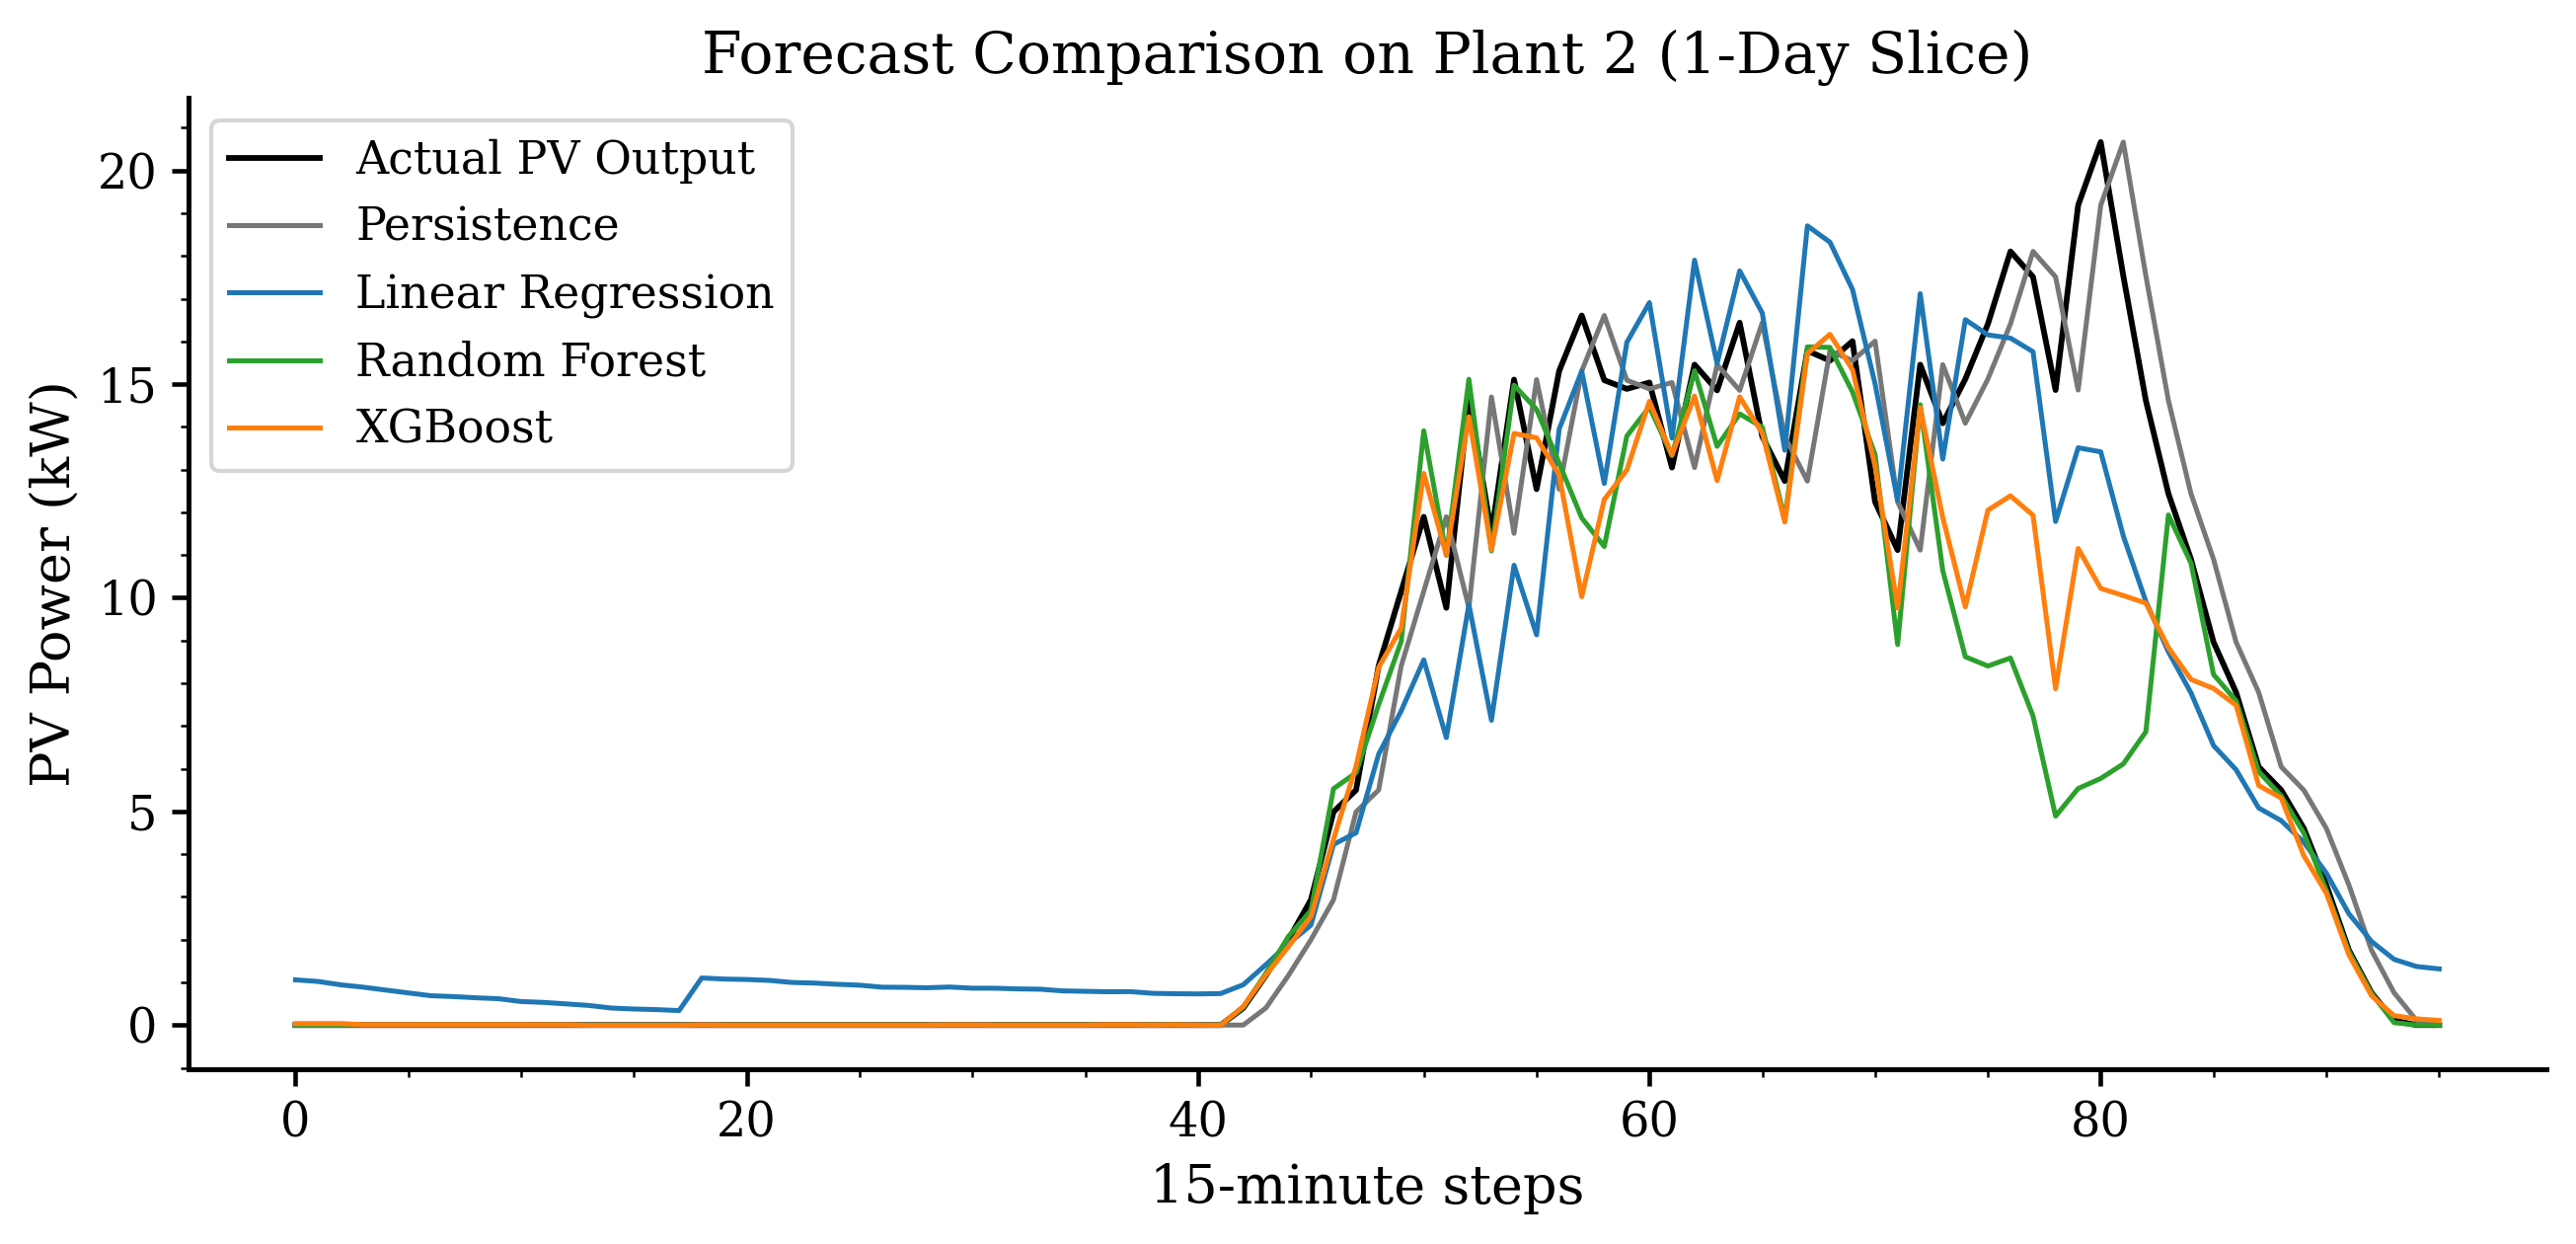

In [43]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "legend.fontsize": 11,
    "figure.dpi": 300,
})

def style_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.minorticks_on()
    ax.tick_params(direction="out", length=4, width=1.1)

# Use N samples
N = 96
actual2 = y_test_p2.values[:N]

# Corresponding predictions
persist2 = y_pred_persist_test_p2.reindex(y_test_p2.index[:N]).values
lr2  = y_pred_lr_p2[:N]
rf2  = y_pred_rf_p2[:N]
xgb2 = y_pred_xgb_p2[:N]

fig, ax = plt.subplots(figsize=(8.8,4.3))
ax.plot(actual2, label="Actual PV Output", color="black", lw=1.4)
ax.plot(persist2, label="Persistence", color="#777", lw=1.2)
ax.plot(lr2, label="Linear Regression", color="#1f77b4", lw=1.2)
ax.plot(rf2, label="Random Forest", color="#2ca02c", lw=1.2)
ax.plot(xgb2, label="XGBoost", color="#ff7f0e", lw=1.2)

ax.set_ylabel("PV Power (kW)")
ax.set_xlabel("15-minute steps")
ax.set_title("Forecast Comparison on Plant 2 (1-Day Slice)")

ax.legend(frameon=True, facecolor="white", loc="best")
style_axes(ax)
plt.tight_layout()
plt.show()

In [54]:
test_ctrl_p2 = control_df_plant2.iloc[int(len(control_df_plant2)*0.7):]

# 1) Rule-based controller
m_rule_p2 = simulate(test_ctrl_p2, rule_controller)

# 2) RL-only (using Q_rl trained on Plant 1)
m_rl_p2 = simulate(test_ctrl_p2, rl_policy)

# 3) Hybrid LR
m_hyb_lr_p2 = sim_hybrid(
    test_ctrl_p2,
    Q_hyb_lr,
    lr_model
)

# 4) Hybrid RF
m_hyb_rf_p2 = sim_hybrid(
    test_ctrl_p2,
    Q_hyb_rf,
    rf_model
)

# 5) Hybrid XGB
m_hyb_xgb_p2 = sim_hybrid(
    test_ctrl_p2,
    Q_hyb_xgb,
    xgb_model
)

print("Control Performance on Plant 2")
print("Rule-based  :", m_rule_p2)
print("RL-only     :", m_rl_p2)
print("Hybrid LR   :", m_hyb_lr_p2)
print("Hybrid RF   :", m_hyb_rf_p2)
print("Hybrid XGB  :", m_hyb_xgb_p2)

Control Performance on Plant 2
Rule-based  : (np.float64(209.064889676255), np.float64(131.625))
RL-only     : (np.float64(30.471399269504367), np.float64(711.75))
Hybrid LR   : (np.float64(12.707214637594024), np.float64(719.625))
Hybrid RF   : (np.float64(15.420874760909314), np.float64(709.875))
Hybrid XGB  : (np.float64(12.693167471071884), np.float64(651.0))


/tmp/ipython-input-1048195736.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(controllers, rotation=20, ha="right")


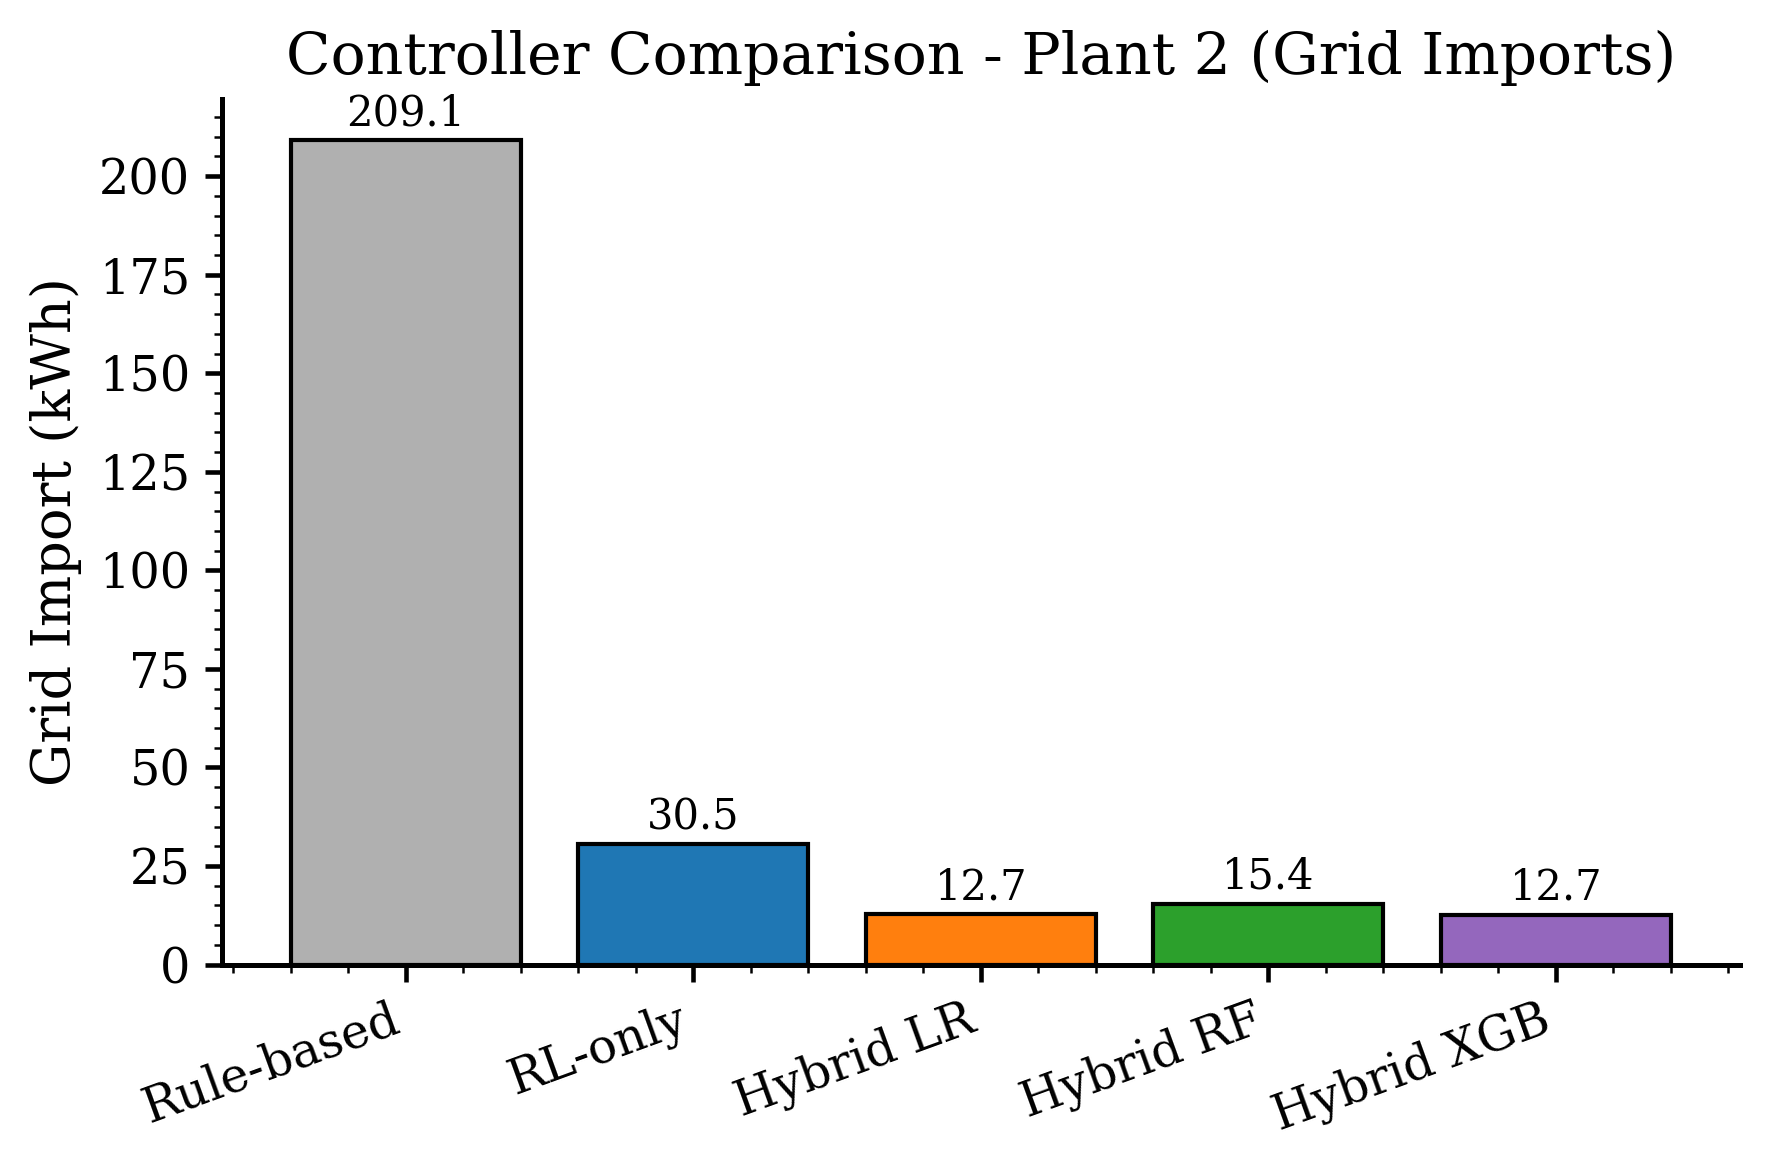

/tmp/ipython-input-1048195736.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(controllers, rotation=20, ha="right")


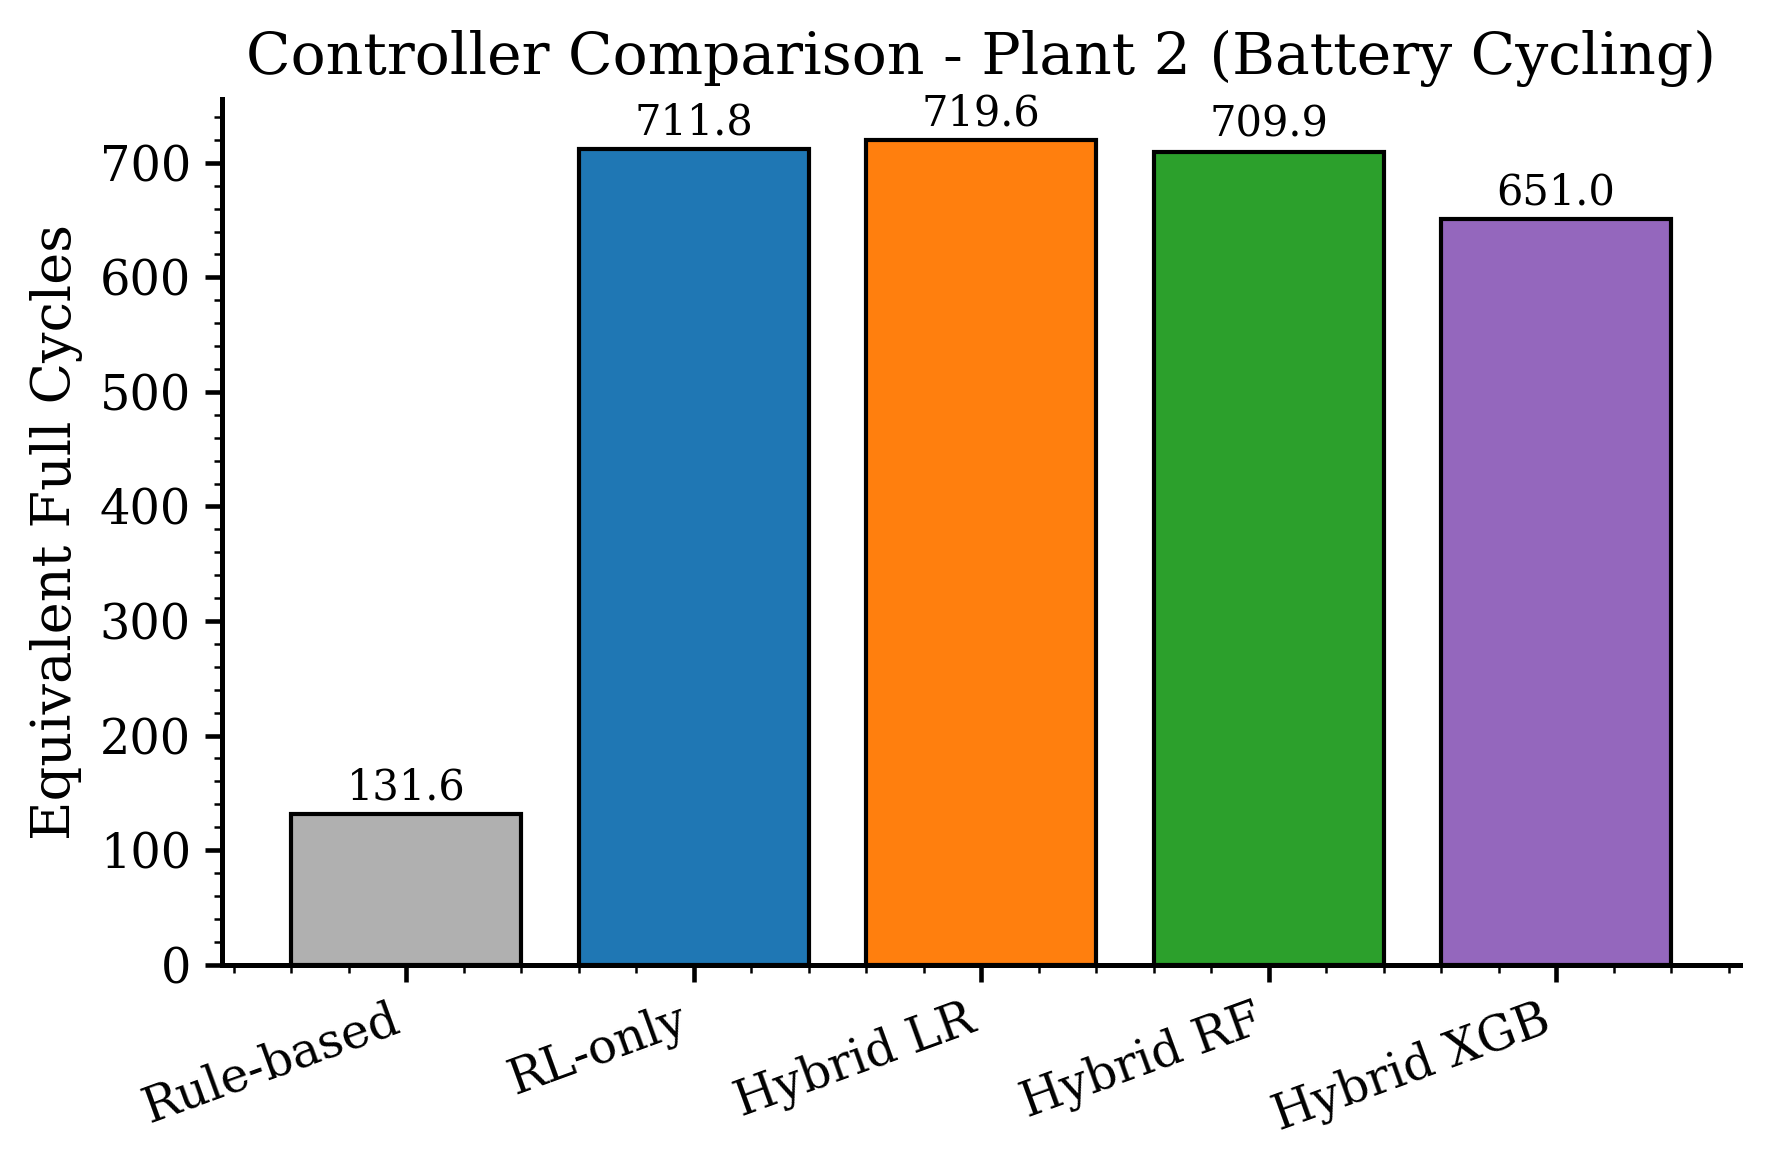

In [47]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "legend.fontsize": 11,
    "figure.dpi": 300,
})

def style_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.minorticks_on()
    ax.tick_params(direction="out", length=4, width=1.1)

controllers = ["Rule-based", "RL-only", "Hybrid LR", "Hybrid RF", "Hybrid XGB"]

grid_imports_p2 = [
    float(m_rule_p2[0]),
    float(m_rl_p2[0]),
    float(m_hyb_lr_p2[0]),
    float(m_hyb_rf_p2[0]),
    float(m_hyb_xgb_p2[0]),
]

cycles_p2 = [
    float(m_rule_p2[1]),
    float(m_rl_p2[1]),
    float(m_hyb_lr_p2[1]),
    float(m_hyb_rf_p2[1]),
    float(m_hyb_xgb_p2[1]),
]

colors = ["#B0B0B0", "#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]

# Grid import
fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(controllers, grid_imports_p2, color=colors, edgecolor="black")
ax.set_ylabel("Grid Import (kWh)")
ax.set_title("Controller Comparison - Plant 2 (Grid Imports)")
for b in bars:
    h = b.get_height()
    ax.text(b.get_x()+b.get_width()/2, h+1.5, f"{h:.1f}", ha="center", va="bottom", fontsize=10)
ax.set_xticklabels(controllers, rotation=20, ha="right")
style_axes(ax)
plt.tight_layout()
plt.show()

# Battery Cycles
fig, ax = plt.subplots(figsize=(6,4))
bars2 = ax.bar(controllers, cycles_p2, color=colors, edgecolor="black")
ax.set_ylabel("Equivalent Full Cycles")
ax.set_title("Controller Comparison - Plant 2 (Battery Cycling)")
for b in bars2:
    h = b.get_height()
    ax.text(b.get_x()+b.get_width()/2, h+5, f"{h:.1f}", ha="center", va="bottom", fontsize=10)
ax.set_xticklabels(controllers, rotation=20, ha="right")
style_axes(ax)
plt.tight_layout()
plt.show()

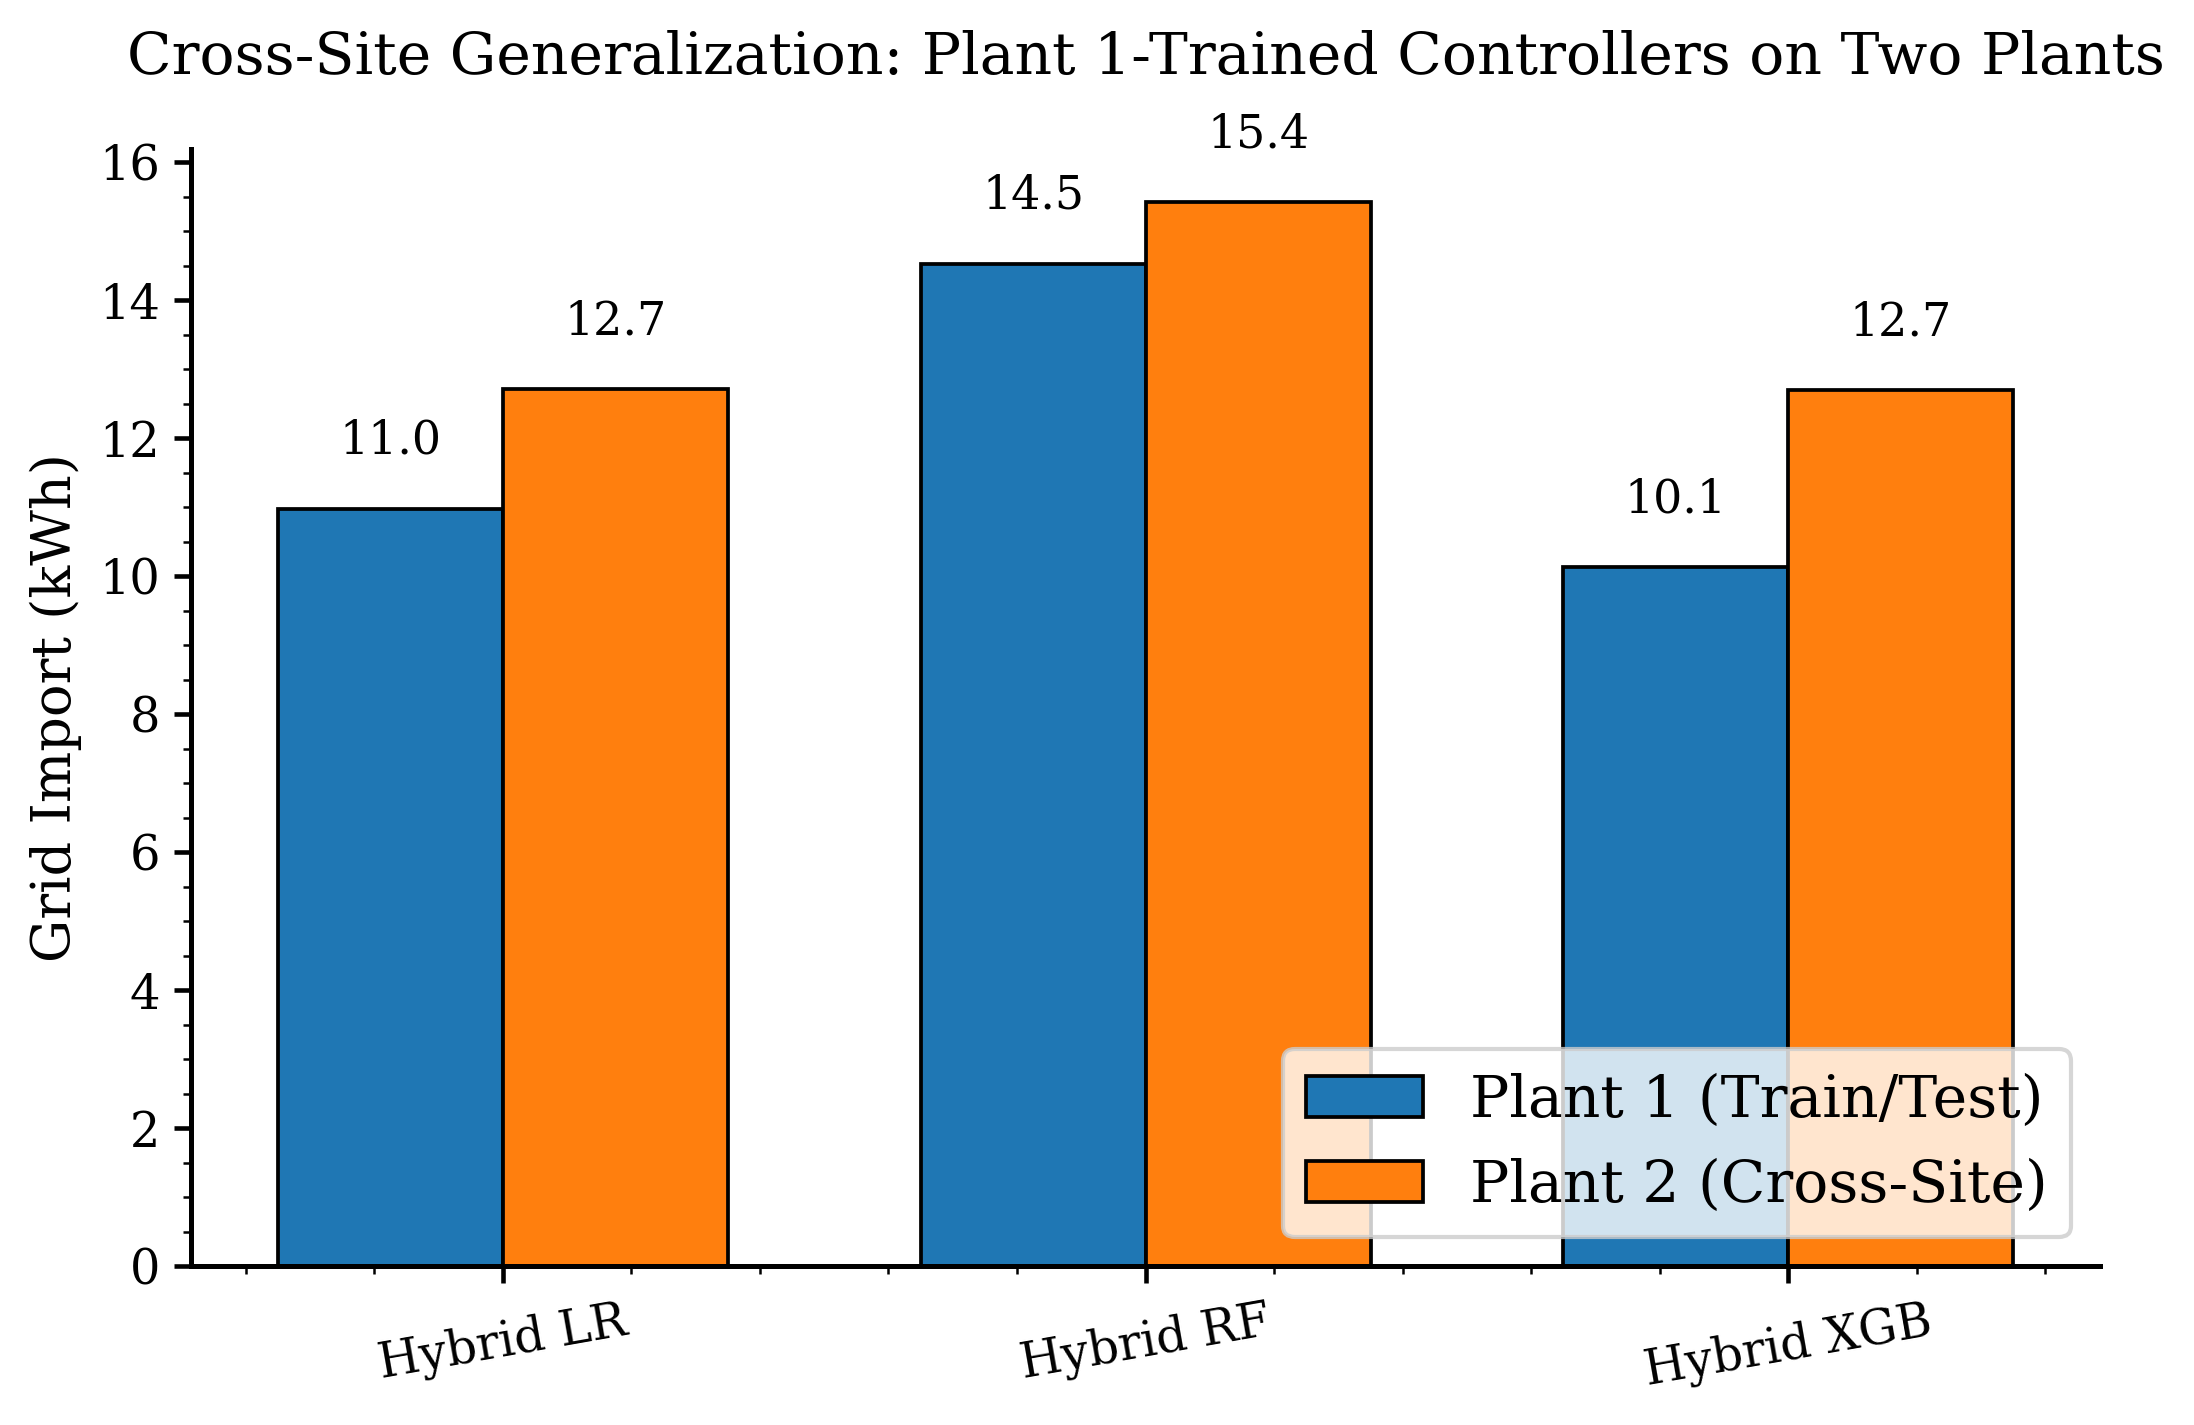

In [53]:
import matplotlib.pyplot as plt
import numpy as np

controllers = ["Hybrid LR", "Hybrid RF", "Hybrid XGB"]

plant1_imports = [
    float(m_hyb_lr[0]),
    float(m_hyb_rf[0]),
    float(m_hyb_xgb[0]),
]

plant2_imports = [
    float(m_hyb_lr_p2[0]),
    float(m_hyb_rf_p2[0]),
    float(m_hyb_xgb_p2[0]),
]

x = np.arange(len(controllers))
width = 0.35

fig, ax = plt.subplots(figsize=(7.2,5.0))

b1 = ax.bar(
    x - width/2, plant1_imports, width,
    label="Plant 1 (Train/Test)",
    color="#1f77b4",
    edgecolor="black",
    linewidth=0.9
)

b2 = ax.bar(
    x + width/2, plant2_imports, width,
    label="Plant 2 (Cross-Site)",
    color="#ff7f0e",
    edgecolor="black",
    linewidth=0.9
)

ax.set_ylabel("Grid Import (kWh)")

ax.set_title("Cross-Site Generalization: Plant 1-Trained Controllers on Two Plants",
             pad=18)

ax.set_xticks(x)
ax.set_xticklabels(controllers, rotation=10)

for bars in [b1, b2]:
    for b in bars:
        h = b.get_height()
        ax.text(
            b.get_x() + b.get_width()/2,
            h + 0.8,
            f"{h:.1f}",
            ha="center",
            fontsize=11
        )

ax.legend(frameon=True, loc="lower right", fontsize=14)

style_axes(ax)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()